In [43]:
# 6. Preprocess PCA on real lesion data
# =========================================================================
import os
import numpy as np
import nibabel as nib
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import joblib

def preprocess_real_lesions_with_pca(real_lesion_path, pca_components):
    """
    Preprocess real lesions with PCA.

    Parameters:
        real_lesion_path (str): Path to the directory containing real lesion .nii.gz files.
        pca_components (int): Number of principal components to retain.

    Returns:
        pca (PCA): Trained PCA model.
        pca_features (np.ndarray): Transformed features after PCA.
    """
    lesion_samples = []
    lesion_files = [f for f in os.listdir(real_lesion_path) if f.endswith('.nii.gz')]
    
    if not lesion_files:
        raise FileNotFoundError(f"No .nii.gz files found in {real_lesion_path}")

    print(f"Found {len(lesion_files)} real lesion files. Processing...")
    for i, lesion_file in enumerate(lesion_files):
        lesion_file_path = os.path.join(real_lesion_path, lesion_file)
        print(f"Processing real lesion {i+1}/{len(lesion_files)}: {lesion_file}")

        # Load lesion data and flatten
        lesion_data = nib.load(lesion_file_path).get_fdata()
        lesion_samples.append(lesion_data.flatten())

    lesion_samples = np.array(lesion_samples)

    # Min-Max normalization?? For each lesion (row) based on its own min and max
    # print("Normalizing real lesion data using Min-Max normalization...")
    # min_vals = np.min(lesion_samples, axis=1, keepdims=True)  # Min value for each lesion (row)
    # max_vals = np.max(lesion_samples, axis=1, keepdims=True)  # Max value for each lesion (row)
    # lesion_samples = (lesion_samples - min_vals) / (max_vals - min_vals)  # Normalize each lesion (row)

    # Perform PCA
    print("Performing PCA...")
    pca = PCA(n_components=pca_components)
    pca_features = pca.fit_transform(lesion_samples)

    # Save PCA model
    joblib.dump(pca, '//cifs.research.erasmusmc.nl/nuge0001/MartijnB/pca_model_real_lesions.joblib')
    joblib.dump(pca_features, '//cifs.research.erasmusmc.nl/nuge0001/MartijnB/pca_features_real_lesions.joblib')

    # Calculate and display explained variance
    cumulative_variance = np.sum(pca.explained_variance_ratio_) * 100
    print(f"Selected {pca_components} components explain {cumulative_variance:.2f}% of the variance in the data.")

    # Print how much data variance each component explains
    for i, variance in enumerate(pca.explained_variance_ratio_):
        print(f"Principal Component {i+1} explains {variance * 100:.2f}% of the variance.")

    return pca, pca_features

# Preprocess the PCA
pca_components = 8
pca, features = preprocess_real_lesions_with_pca(r"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\ExtractedLesions", pca_components)

Found 22 real lesion files. Processing...
Processing real lesion 1/22: EMC0016_L45.nii.gz
Processing real lesion 2/22: EMC0019_L12.nii.gz
Processing real lesion 3/22: EMC0036_L12.nii.gz
Processing real lesion 4/22: EMC0036_L23.nii.gz
Processing real lesion 5/22: EMC0036_L45.nii.gz
Processing real lesion 6/22: EMC0042_L34.nii.gz
Processing real lesion 7/22: EMC0042_L45.nii.gz
Processing real lesion 8/22: EMC0043_L23.nii.gz
Processing real lesion 9/22: EMC0045_L23.nii.gz
Processing real lesion 10/22: EMC0045_L34.nii.gz
Processing real lesion 11/22: EMC0045_LR23.nii.gz
Processing real lesion 12/22: EMC0046_LR45.nii.gz
Processing real lesion 13/22: IKZ0002_L23.nii.gz
Processing real lesion 14/22: IKZ0002_L34.nii.gz
Processing real lesion 15/22: IKZ0002_L45.nii.gz
Processing real lesion 16/22: IKZ0008_L34.nii.gz
Processing real lesion 17/22: IKZ0008_L45.nii.gz
Processing real lesion 18/22: YSL0002_L45.nii.gz
Processing real lesion 19/22: YSL0010_L12.nii.gz
Processing real lesion 20/22: YSL0

Patient EMC0016: Spine Z-range = [288, 361]
Patient EMC0016, Lesion EMC0016_L45.nii.gz: CoM Z = 296.07575757575756
Patient EMC0016, Lesion EMC0016_L45.nii.gz: Normalized Z = 0.110626816106268
Patient EMC0019: Spine Z-range = [268, 342]
Patient EMC0019, Lesion EMC0019_L12.nii.gz: CoM Z = 267.15625
Patient EMC0019, Lesion EMC0019_L12.nii.gz: Normalized Z = 0.0
Patient EMC0036: Spine Z-range = [235, 301]
Patient EMC0036, Lesion EMC0036_L12.nii.gz: CoM Z = 271.61538461538464
Patient EMC0036, Lesion EMC0036_L12.nii.gz: Normalized Z = 0.5547785547785552
Patient EMC0036, Lesion EMC0036_L23.nii.gz: CoM Z = 264.81632653061223
Patient EMC0036, Lesion EMC0036_L23.nii.gz: Normalized Z = 0.4517625231910944
Patient EMC0036, Lesion EMC0036_L45.nii.gz: CoM Z = 245.72413793103448
Patient EMC0036, Lesion EMC0036_L45.nii.gz: Normalized Z = 0.16248693834900724
Patient EMC0042: Spine Z-range = [313, 390]
Patient EMC0042, Lesion EMC0042_L34.nii.gz: CoM Z = 341.31226765799255
Patient EMC0042, Lesion EMC0042_

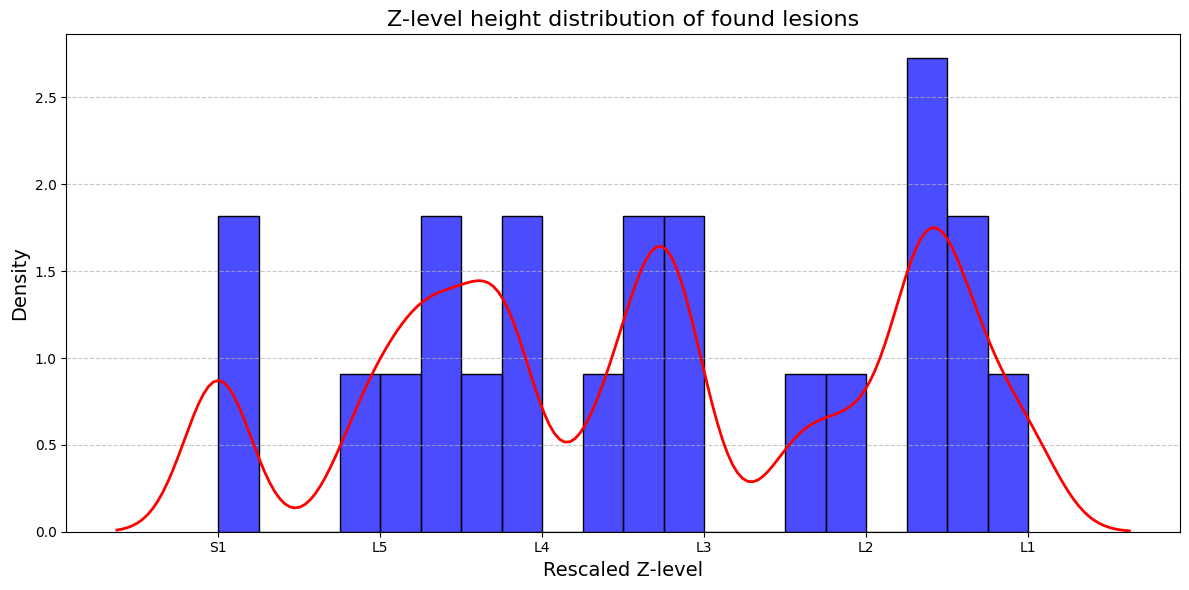

In [49]:
# 7. Determine z-level distribution of the real lesions
# Used during the insertion to insert lesions at locations where lesions are most often found
# ========================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from scipy.ndimage import center_of_mass
from scipy.stats import gaussian_kde

def normalize_and_visualize_lesion_com(
    lesion_dir, 
    spine_dir_template, 
    patient_ids, 
    output_csv=r'\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\normalized_com_z_levels.csv', 
    kde_output_file=r'\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\kde_distribution.npy',
    bandwidth=0.5
):
    """
    Normalize lesion center-of-mass (CoM) z-levels based on spinal segmentations and visualize results.
    Save the KDE distribution for future use.

    Parameters:
        lesion_dir (str): Directory containing lesion masks.
        spine_dir_template (str): Template path to spinal segmentation mask (with {patient_ID} placeholder).
        patient_ids (list): List of patient IDs to process.
        output_csv (str): Output CSV file to save normalized z-levels.
        kde_output_file (str): Output file to save the KDE distribution.
        bandwidth (float): Bandwidth for KDE smoothing.
    """
    normalized_z_levels = []  # List to store all normalized z-levels

    # First pass: Normalize z_com values for each patient
    for patient_id in patient_ids:
        # Paths for lesion masks and spinal segmentation
        spine_path = spine_dir_template.format(patient_ID=patient_id)
        lesion_files = [f for f in os.listdir(lesion_dir) if f.startswith(patient_id)]

        # Load spinal segmentation and determine min/max z-coordinates
        try:
            spine_nii = nib.load(spine_path)
            spine_data = spine_nii.get_fdata()
        except FileNotFoundError:
            print(f"Spinal segmentation not found for patient {patient_id}. Skipping.")
            continue

        # Get non-zero z-coordinates from spinal segmentation
        z_coords_spine = np.nonzero(spine_data)[2]
        if z_coords_spine.size == 0:
            print(f"No spinal segmentation data found for patient {patient_id}. Skipping.")
            continue

        min_z_spine, max_z_spine = z_coords_spine.min(), z_coords_spine.max()
        print(f"Patient {patient_id}: Spine Z-range = [{min_z_spine}, {max_z_spine}]")

        # Process each lesion mask for the current patient
        for lesion_file in lesion_files:
            lesion_path = os.path.join(lesion_dir, lesion_file)
            try:
                lesion_nii = nib.load(lesion_path)
                lesion_data = lesion_nii.get_fdata()
            except FileNotFoundError:
                print(f"Lesion mask not found: {lesion_path}. Skipping.")
                continue

            # Compute center of mass (CoM) of the lesion
            if lesion_data.sum() == 0:
                print(f"Empty lesion mask: {lesion_file}. Skipping.")
                continue

            com = center_of_mass(lesion_data)
            z_com = com[2]  # Extract z-coordinate of CoM
            print(f"Patient {patient_id}, Lesion {lesion_file}: CoM Z = {z_com}")

            # Normalize CoM z-coordinate to the range [0, 1] based on spine bounds
            normalized_z = (z_com - min_z_spine) / (max_z_spine - min_z_spine)

            # Ensure values are in [0, 1] (clip outliers caused by incorrect calculations)
            normalized_z = np.clip(normalized_z, 0, 1)

            print(f"Patient {patient_id}, Lesion {lesion_file}: Normalized Z = {normalized_z}")
            normalized_z_levels.append(normalized_z)

    # Step 2: Find the largest normalized z-level
    max_normalized_z = max(normalized_z_levels)
    print(f"Largest normalized z-level across all lesions: {max_normalized_z}")

    # Step 3: Rescale the already normalized z-levels
    rescaled_z_levels = [z / max_normalized_z for z in normalized_z_levels]

    # Ensure values are in [0, 1] (clip outliers caused by incorrect calculations)
    rescaled_z_levels = np.clip(rescaled_z_levels, 0, 1)

    # Save rescaled normalized CoM z-levels to CSV
    normalized_z_df = pd.DataFrame({'rescaled_normalized_com_z': rescaled_z_levels})
    normalized_z_df.to_csv(output_csv, index=False)
    print(f"Rescaled normalized CoM z-levels saved to {output_csv}.")

    # Step 4: Compute the KDE distribution
    kde = gaussian_kde(rescaled_z_levels, bw_method=bandwidth)
    
    # Get the range for the KDE plot and sample it
    z_range = np.linspace(0, 1, 1000)  # Use a fine grid of values between 0 and 1
    kde_values = kde(z_range)
    
    # Save the KDE distribution to a file (e.g., .npy for easy future use)
    np.save(kde_output_file, {'z_range': z_range, 'kde_values': kde_values})
    print(f"KDE distribution saved to {kde_output_file}.")

    # Plot histogram and KDE
    plt.figure(figsize=(12, 6))
    sns.histplot(
        rescaled_z_levels, bins=20, kde=False, color='blue', alpha=0.7, stat='density'
    )
    sns.kdeplot(
        rescaled_z_levels, bw_adjust=bandwidth, color='red', lw=2  # KDE line in red
    )
    
    plt.title('Z-level height distribution of found lesions', fontsize=16)
    plt.xlabel('Rescaled Z-level', fontsize=14)
    plt.ylabel('Density', fontsize=14)

    # Custom ticks for spine levels
    tick_labels = ["S1", "L5", "L4", "L3", "L2", "L1"]
    tick_positions = np.linspace(0, 1, len(tick_labels))  # Evenly spaced positions along [0, 1]
    ax = plt.gca()
    ax.set_xticks(tick_positions)  # Set tick positions
    ax.set_xticklabels(tick_labels)  # Set tick labels

    # Adjust grid and layout
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# Example usage
lesion_dir = '//cifs.research.erasmusmc.nl/nuge0001/MartijnB/Lesion_Masks_PET'
spine_dir_template = '//cifs.research.erasmusmc.nl/nuge0001/Nick/{patient_ID}/PET_spinal_canal_only.nii.gz'
patient_ids = [
    "EMC0016", "EMC0019", "EMC0036", "EMC0042", "EMC0043", 
    "EMC0045", "EMC0046", "IKZ0002", "IKZ0008", "YSL0002", "YSL0010"
]

normalize_and_visualize_lesion_com(lesion_dir, spine_dir_template, patient_ids, bandwidth=0.25)

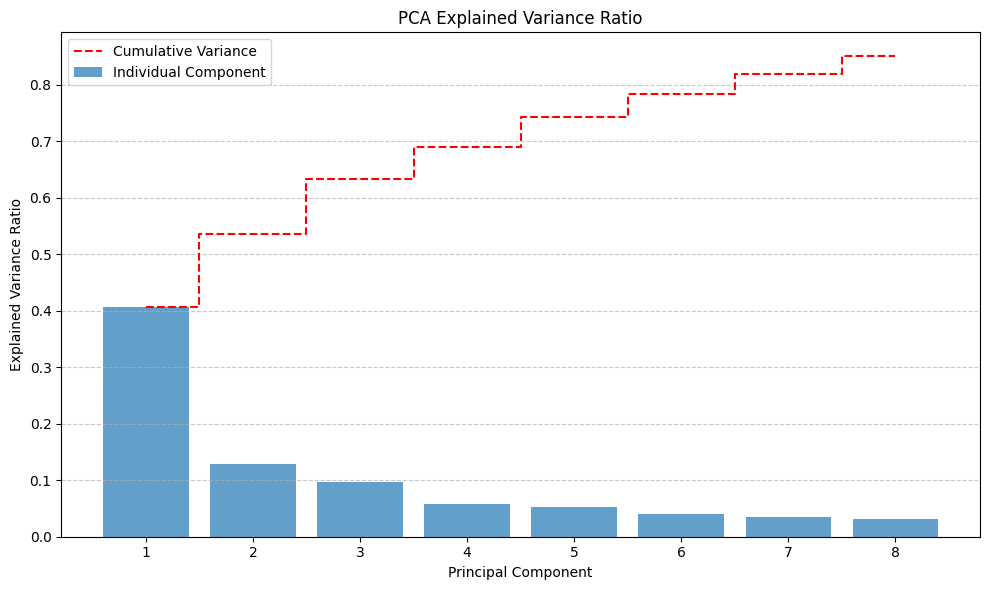

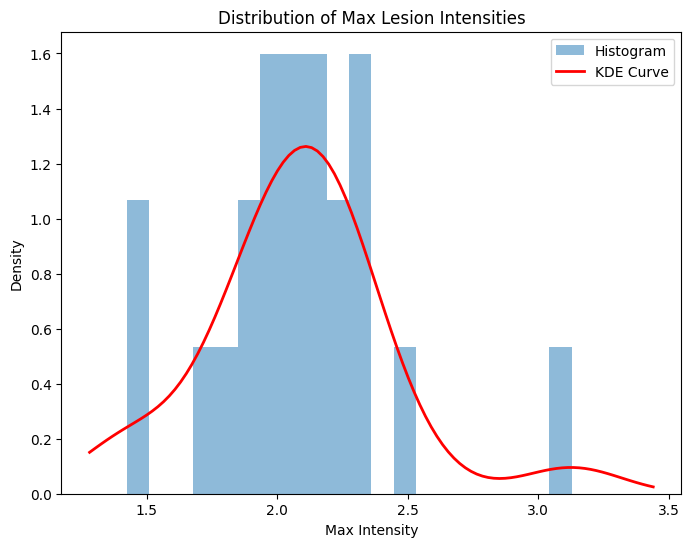

No lesion inserted
Image 1 Number of lesions to insert: 2
Image 2 Number of lesions to insert: 3
Image 3 Number of lesions to insert: 2
Image 4 Number of lesions to insert: 2
Image 5 Number of lesions to insert: 4
Image 6 Number of lesions to insert: 3
Image 7 Number of lesions to insert: 4
Image 8 Number of lesions to insert: 1
No lesion inserted
Image 10 Number of lesions to insert: 3
Image 11 Number of lesions to insert: 4
Image 12 Number of lesions to insert: 3
Image 13 Number of lesions to insert: 4
No lesion inserted
Image 15 Number of lesions to insert: 4
No lesion inserted
Image 17 Number of lesions to insert: 2
Image 18 Number of lesions to insert: 3
Image 19 Number of lesions to insert: 1
Image 20 Number of lesions to insert: 3
No lesion inserted
Image 22 Number of lesions to insert: 4
Image 23 Number of lesions to insert: 3
Image 24 Number of lesions to insert: 4
No lesion inserted
Image 26 Number of lesions to insert: 2
Image 27 Number of lesions to insert: 4
Image 28 Numbe

In [48]:
# 8. Insert lesions into PET patients and generate a dataset (images + lesion masks)
# =============================================================================================

import numpy as np
import SimpleITK as sitk
from scipy.ndimage import center_of_mass
import joblib
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import os
import nibabel as nib
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from scipy.ndimage import gaussian_filter
import scipy.ndimage as ndimage
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting

def load_image(path):
    """Load an image using SimpleITK."""
    return sitk.ReadImage(path)

def compute_center_of_mass(mask_array):
    """Compute the center of mass for a given mask array."""
    return center_of_mass(mask_array > 0)

def threshold_and_center_lesion(lesion_array, threshold=0.1):
    """Threshold the lesion and compute its center of mass."""
    lesion_array[lesion_array < threshold] = 0  # Apply threshold
    lesion_com = compute_center_of_mass(lesion_array)
    return lesion_array, lesion_com

def process_real_lesion(real_lesion_path):
    lesion_samples = []
    lesion_files = [f for f in os.listdir(real_lesion_path) if f.endswith('.nii.gz')]
    if not lesion_files:
        raise FileNotFoundError(f"No .nii.gz files found in {real_lesion_path}")

    # print(f"Found {len(lesion_files)} real lesion files. Processing...")
    for i, lesion_file in enumerate(lesion_files):
        lesion_file_path = os.path.join(real_lesion_path, lesion_file)
        # print(f"Processing real lesion {i+1}/{len(lesion_files)}: {lesion_file}")
        
        # Load lesion data and resize
        lesion_data = nib.load(lesion_file_path).get_fdata()
        lesion_samples.append(lesion_data.flatten())

    # Min-Max normalization for each lesion (row) based on its own min and max
    min_vals = np.min(lesion_samples, axis=1, keepdims=True)  # Min value for each lesion (row)
    max_vals = np.max(lesion_samples, axis=1, keepdims=True)  # Max value for each lesion (row)

    # Normalize each lesion (row) independently
    lesion_samples = (lesion_samples - min_vals) / (max_vals - min_vals)

    return lesion_samples

def pca_kde_sampling_with_plot(pca, pca_features, real_lesion_path, num_samples):

    real_lesion_samples = process_real_lesion(real_lesion_path)

    real_pca_features = pca.transform(real_lesion_samples)

    # Fit KDE for each PCA component
    kde_samples = []
    for i in range(pca_features.shape[1]):
        # Extract values of the i-th PCA component
        component_values = real_pca_features[:, i]

        # Fit KDE to the component
        kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(component_values[:, np.newaxis])

        # Sample new values for this component
        samples = kde.sample(num_samples).flatten()
        kde_samples.append(samples)

        # Plot the KDE distribution for the first 5 components
        x_d = np.linspace(min(component_values) - 0.5, max(component_values) + 0.5, 1000)
        log_dens = kde.score_samples(x_d[:, np.newaxis])
        plt.figure(figsize=(6, 4))
        plt.plot(x_d, np.exp(log_dens), label=f"Component {i+1} KDE")
        plt.hist(component_values, bins=20, density=True, alpha=0.5, label="Histogram")
        plt.title(f"KDE of PCA Component {i+1}")
        plt.xlabel("Value")
        plt.ylabel("Density")
        plt.legend()
        plt.grid()
        plt.show()

    kde_samples = np.stack(kde_samples, axis=1)

    return kde_samples

def pca_gmm_sampling_with_plot(pca, pca_features, real_lesion_path, num_samples):
    # Process real lesion data
    real_lesion_samples = process_real_lesion(real_lesion_path)

    # Apply PCA transformation to the real lesion data
    real_pca_features = pca.transform(real_lesion_samples)

    # Fit GMM on the PCA-transformed features
    gmm = GaussianMixture(n_components=5, covariance_type='full')
    gmm.fit(real_pca_features)

    # Sample new points from the GMM
    gmm_samples, _ = gmm.sample(num_samples)

    # Plot the GMM distribution in 2D (assuming 2 PCA components)
    if real_pca_features.shape[1] == 2:  # Only plot if it's 2D PCA for visualization
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Scatter plot of the original real data
        ax.scatter(real_pca_features[:, 0], real_pca_features[:, 1], alpha=0.7, c='blue', edgecolors='k')

        # Plot the sampled GMM points
        ax.scatter(gmm_samples[:, 0], gmm_samples[:, 1], alpha=0.7, c='red', edgecolors='k', marker='x')

        # Plot the GMM components as ellipses
        for i in range(gmm.n_components):
            mean = gmm.means_[i]
            cov = gmm.covariances_[i]
            
            # Create an ellipse for the covariance matrix of each Gaussian
            v, w = np.linalg.eigh(cov)
            v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
            w = w.T
            
            angle = np.arctan(w[0, 1] / w[0, 0]) * 180.0 / np.pi
            angle = 180.0 if angle < 0 else angle
            ell = Ellipse(xy=mean, width=v[0], height=v[1], angle=angle, color='red', alpha=0.5)
            ax.add_patch(ell)

        ax.set_title("PCA Components with GMM Sampling")
        ax.set_xlabel("First PCA Component")
        ax.set_ylabel("Second PCA Component")
        plt.grid(True)
        plt.show()

    # Plot in 3D with ellipsoids
    elif real_pca_features.shape[1] == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Scatter plot of the original real data
        ax.scatter(real_pca_features[:, 0], real_pca_features[:, 1], real_pca_features[:, 2], 
                   alpha=0.7, c='blue', edgecolors='k', label="Real Lesions")

        # Plot the sampled GMM points
        ax.scatter(gmm_samples[:, 0], gmm_samples[:, 1], gmm_samples[:, 2], 
                   alpha=0.7, c='red', edgecolors='k', marker='x', label="GMM Samples")

        # Plot the GMM components as ellipsoids
        for i in range(gmm.n_components):
            plot_ellipsoid(ax, gmm.means_[i], gmm.covariances_[i])

        ax.set_title("PCA Components with GMM Sampling (3D)")
        ax.set_xlabel("First PCA Component")
        ax.set_ylabel("Second PCA Component")
        ax.set_zlabel("Third PCA Component")
        ax.legend()
        plt.show()
    
    return gmm_samples

def preprocess_lesions_with_pca(real_lesion_path, pca, pca_features, lesion_shape=(24, 24, 24), pca_components=100):
    # Calculate and display explained variance
    # cumulative_variance = np.sum(pca.explained_variance_ratio_) * 100
    # print(f"Selected 100 components explain {cumulative_variance:.2f}% of the variance in the data.")

    # Display individual component variance
    # for i, variance in enumerate(pca.explained_variance_ratio_):
        # print(f"Component {i+1} explains {variance * 100:.2f}% of the variance")

    kde_samples = pca_gmm_sampling_with_plot(pca, pca_features, real_lesion_path, num_samples=1)
    return kde_samples

def plot_lesion_top_values_histogram_with_kde(lesion_values, bandwidth):

    # Compute KDE
    kde = gaussian_kde(lesion_values, bw_method='scott')
    kde.set_bandwidth(kde.factor * bandwidth)
    kde_x = np.linspace(min(lesion_values), max(lesion_values), 500)
    kde_y = kde(kde_x)

    return kde

def sample_from_kde(kde, num_samples=1):
    """
    Sample values from a KDE distribution.

    Parameters:
        kde (gaussian_kde): The KDE object fitted to lesion values.
        num_samples (int): Number of samples to draw.

    Returns:
        numpy.ndarray: Random samples from the KDE.
    """
    return kde.resample(num_samples).flatten()

def sample_z_level_from_kde(kde, num_samples=1):
    """Sample a z-level from the KDE distribution."""
    return kde.resample(num_samples).flatten()

def insert_lesion_into_petOLD(pet_image, mask_image, lesion_array, kde_z):
    """
    Insert a lesion into the PET image at a specific z-level sampled from the KDE distribution,
    scaling the maximum value of the lesion by a random factor between 1.0 and 1.25.

    If no valid (x, y) locations are found at the sampled z-level, the function skips insertion.
    """
    pet_array = sitk.GetArrayFromImage(pet_image)
    mask_array = sitk.GetArrayFromImage(mask_image)

    # Rescale the lesion's non-zero voxels by a random factor between 1.0 and 1.25
    scaling_factor = np.random.uniform(1, 1.25)
    lesion_array = np.where(lesion_array > 0.1, lesion_array * scaling_factor, lesion_array)

    # Get the z-level range from the non-zero mask
    non_zero_z = np.any(mask_array > 0, axis=(1, 2))
    non_zero_z_indices = np.where(non_zero_z)[0]

    if len(non_zero_z_indices) == 0:
        print("No valid z-levels found in the mask.")
        return None, None

    z_min, z_max = non_zero_z_indices[0], non_zero_z_indices[-1]
    z_level = z_min + kde_z * (z_max - z_min)
    z_level_index = int(np.round(z_level))
    z_level_index = max(z_min, min(z_max, z_level_index))

    # Get a random (x, y) location from the mask at the selected z-level
    mask_voxels = np.argwhere(mask_array[z_level_index] > 0)
    if mask_voxels.size == 0:
        print(f"No valid (x, y) locations found at z-level {z_level_index}. Skipping this lesion insertion.")
        return None, None

    random_xy_voxel = mask_voxels[random.randint(0, len(mask_voxels) - 1)]
    random_voxel = np.array([z_level_index, *random_xy_voxel])

    # Calculate the insertion region
    lesion_shape = lesion_array.shape
    lesion_com = np.array(compute_center_of_mass(lesion_array)).astype(int)
    start = random_voxel - lesion_com
    end = start + lesion_shape

    # Ensure the region is within bounds
    slices_pet, slices_lesion = [], []
    for i in range(3):
        lesion_start = max(0, -start[i])
        pet_start = max(0, start[i])
        pet_end = min(pet_array.shape[i], end[i])
        lesion_end = lesion_start + (pet_end - pet_start)

        slices_pet.append(slice(pet_start, pet_end))
        slices_lesion.append(slice(lesion_start, lesion_end))

    slices_pet = tuple(slices_pet)
    slices_lesion = tuple(slices_lesion)

    # Replace PET values with non-zero lesion values and create a binary mask
    binary_lesion_mask = np.zeros_like(pet_array, dtype=np.uint8)
    lesion_region = lesion_array[slices_lesion]
    pet_region = pet_array[slices_pet]

    # Insert only non-zero lesion values
    non_zero_mask = lesion_region > 0
    pet_region[non_zero_mask] = lesion_region[non_zero_mask]
    binary_lesion_mask[slices_pet][non_zero_mask] = 1

    # Save the modified PET image and binary mask
    pet_with_lesion = sitk.GetImageFromArray(pet_array)
    pet_with_lesion.CopyInformation(pet_image)

    binary_lesion_image = sitk.GetImageFromArray(binary_lesion_mask)
    binary_lesion_image.CopyInformation(pet_image)

    return pet_with_lesion, binary_lesion_image

def insert_lesion_into_pet(pet_image, mask_image, lesion_array, kde_z, sampled_kde_max):
    """
    Insert a lesion into the PET image at a specific z-level sampled from the KDE distribution,
    scaling the maximum value of the lesion by a factor based on the original max.

    The lesion intensity is rescaled so that its **minimum nonzero value** matches 
    the median PET value at the insertion location, while keeping the maximum unchanged.

    If no valid (x, y) locations are found at the sampled z-level, the function skips insertion.
    """
    pet_array = sitk.GetArrayFromImage(pet_image)
    mask_array = sitk.GetArrayFromImage(mask_image)

    # Compute the current maximum intensity of the lesion
    current_max = lesion_array.max()
    # Compute the scaling factor to match the new max intensity
    scaling_factor = sampled_kde_max / current_max if current_max > 0 else 1.0
    # Apply scaling only to nonzero intensities, keeping the minimum unchanged
    lesion_array = np.where(lesion_array > 0, lesion_array*scaling_factor, lesion_array)
    # plot_lesion_3d(lesion_array)

    # Get the z-level range from the non-zero mask
    non_zero_z = np.any(mask_array > 0, axis=(1, 2))
    non_zero_z_indices = np.where(non_zero_z)[0]

    if len(non_zero_z_indices) == 0:
        print("No valid z-levels found in the mask.")
        return None, None

    z_min, z_max = non_zero_z_indices[0], non_zero_z_indices[-1]
    z_level = z_min + kde_z * (z_max - z_min)
    z_level_index = int(np.round(z_level))
    z_level_index = max(z_min, min(z_max, z_level_index))

    # Get a random (x, y) location from the mask at the selected z-level
    mask_voxels = np.argwhere(mask_array[z_level_index] > 0)
    if mask_voxels.size == 0:
        print(f"No valid (x, y) locations found at z-level {z_level_index}. Skipping this lesion insertion.")
        return None, None

    random_xy_voxel = mask_voxels[random.randint(0, len(mask_voxels) - 1)]
    random_voxel = np.array([z_level_index, *random_xy_voxel])

    # Calculate the insertion region
    lesion_shape = lesion_array.shape
    lesion_com = np.array(compute_center_of_mass(lesion_array)).astype(int)
    start = random_voxel - lesion_com
    end = start + lesion_shape

    # Ensure the region is within bounds
    slices_pet, slices_lesion = [], []
    for i in range(3):
        lesion_start = max(0, -start[i])
        pet_start = max(0, start[i])
        pet_end = min(pet_array.shape[i], end[i])
        lesion_end = lesion_start + (pet_end - pet_start)

        slices_pet.append(slice(pet_start, pet_end))
        slices_lesion.append(slice(lesion_start, lesion_end))

    slices_pet = tuple(slices_pet)
    slices_lesion = tuple(slices_lesion)

    # Extract lesion and PET region for intensity rescaling
    lesion_region = lesion_array[slices_lesion]
    pet_region = pet_array[slices_pet]
    lesion_mask = lesion_region > 0

    if np.any(lesion_mask):
        pet_values_at_lesion = pet_region[lesion_mask]
        median_pet_value = np.median(pet_values_at_lesion)

        # Extract only nonzero lesion values for proper scaling
        lesion_nonzero = lesion_region[lesion_mask]
        lesion_max = lesion_nonzero.max()
        lesion_min = lesion_nonzero.min()

        if lesion_max - lesion_min > 0:
            lesion_rescaled = np.copy(lesion_region)
            lesion_rescaled[lesion_mask] = (lesion_nonzero - lesion_min) / (lesion_max - lesion_min)  # Normalize to [0,1]
            lesion_rescaled[lesion_mask] = lesion_rescaled[lesion_mask] * (lesion_max - median_pet_value) + median_pet_value  # Scale

            # Insert rescaled lesion into PET image
            pet_region[lesion_mask] = lesion_rescaled[lesion_mask]

    # Create a binary mask of the inserted lesion
    binary_lesion_mask = np.zeros_like(pet_array, dtype=np.uint8)
    binary_lesion_mask[slices_pet][lesion_mask] = 1

    # Save the modified PET image and binary mask
    pet_with_lesion = sitk.GetImageFromArray(pet_array)
    pet_with_lesion.CopyInformation(pet_image)

    binary_lesion_image = sitk.GetImageFromArray(binary_lesion_mask)
    binary_lesion_image.CopyInformation(pet_image)

    return pet_with_lesion, binary_lesion_image

def plot_pca_variance_explained(pca):
    """
    Plot the explained variance ratio for each PCA component.

    Parameters:
        pca (sklearn.decomposition.PCA): The PCA object containing the explained variance data.
    """
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 
            alpha=0.7, label='Individual Component')
    plt.step(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 
             where='mid', linestyle='--', color='red', label='Cumulative Variance')

    plt.title('PCA Explained Variance Ratio')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.xticks(range(1, len(explained_variance_ratio) + 1))
    plt.legend(loc='best')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def apply_affine_transform(image_array, mask_array, max_shear=0.04, max_translation=4):
    """
    Apply a small shear and translation to both the image and mask.

    Parameters:
        image_array (numpy.ndarray): The input PET image array.
        mask_array (numpy.ndarray): The input mask array.
        max_shear (float): Maximum shear value (small perturbation).
        max_translation (int): Maximum number of pixels for translation.

    Returns:
        tuple: (Transformed image array, Transformed mask array)
    """
    # Generate a small random shear matrix
    shear_x = np.random.uniform(-max_shear, max_shear)
    shear_y = np.random.uniform(-max_shear, max_shear)
    shear_z = np.random.uniform(-max_shear, max_shear)

    shear_matrix = np.array([
        [1, shear_x, shear_y, 0],
        [shear_x, 1, shear_z, 0],
        [shear_y, shear_z, 1, 0],
        [0, 0, 0, 1]
    ])

    # Generate a small random translation
    translation = np.random.randint(-max_translation, max_translation + 1, size=3)

    # Apply affine transformation to image and mask
    transformed_image = ndimage.affine_transform(image_array, shear_matrix[:3, :3], offset=translation, order=1)
    transformed_mask = ndimage.affine_transform(mask_array, shear_matrix[:3, :3], offset=translation, order=0)

    return transformed_image, transformed_mask

def add_noise_and_blur(image, noise_std=0.05, blur_sigma_range=(0.5, 2.0)):
    """
    Add small random noise and random blur to an image.
    
    Args:
        image (numpy.ndarray): The input image array.
        noise_std (float): Standard deviation of the Gaussian noise to be added.
        blur_sigma_range (tuple): The range (min, max) from which to sample the blur sigma value.
    
    Returns:
        numpy.ndarray: Augmented image.
    """
    # Add random Gaussian noise
    noise = np.random.normal(0, noise_std, image.shape)
    noisy_image = image + noise
    
    # Apply random Gaussian blur (sample sigma from blur_sigma_range)
    blur_sigma = np.random.uniform(blur_sigma_range[0], blur_sigma_range[1])
    transformed_image = gaussian_filter(noisy_image, sigma=blur_sigma)
    
    return transformed_image

def get_random_image_mask_pair(image_dir, mask_dir):
    """Randomly select an image and corresponding mask pair."""
    images = [f for f in os.listdir(image_dir) if f.endswith('_0001.nii.gz')]
    if not images:
        raise FileNotFoundError("No valid images found in directory.")
    
    selected_image = random.choice(images)
    mask_name = f"spinal_cord_{selected_image}"
    mask_path = os.path.join(mask_dir, mask_name)
    image_path = os.path.join(image_dir, selected_image)
    
    if not os.path.exists(mask_path):
        raise FileNotFoundError(f"Corresponding mask not found for {selected_image}.")
    
    return image_path, mask_path, selected_image[:-12]

def plot_lesion_3d(lesion_array):
    """ Plot the extracted lesion in 3D with a colorbar. """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    nonzero_voxels = np.argwhere(lesion_array > 0)
    values = lesion_array[lesion_array > 0]
    
    sc = ax.scatter(nonzero_voxels[:, 0], nonzero_voxels[:, 1], nonzero_voxels[:, 2], 
                    c=values, cmap='hot', marker='o')
    ax.set_title('3D Visualization of Extracted Lesion')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 12)
    ax.set_zlim(0, 12)
    fig.colorbar(sc, ax=ax, label='Voxel Intensity')
    plt.show()
    
def sample_z_from_kde(kde_values, z_range):
    # Use the KDE values to sample a z-level. We can use np.random.choice for sampling.
    z_level = np.random.choice(z_range, p=kde_values / kde_values.sum())  # Normalize the KDE
    return z_level

def plot_ellipsoid(ax, mean, cov, color='red', alpha=0.2):
    """Plot a correctly scaled 3D Gaussian ellipsoid."""
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 30)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))

    # Compute eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov)
    radii = 2.0 * np.sqrt(eigvals)  # Apply scaling factor for 95% confidence region

    # Transform unit sphere
    xyz = np.array([x.ravel(), y.ravel(), z.ravel()])
    transformed_xyz = eigvecs @ (radii[:, None] * xyz)  # Correct transformation
    x_t, y_t, z_t = transformed_xyz.reshape(3, *x.shape)

    # Shift ellipsoid to Gaussian mean
    x_t += mean[0]
    y_t += mean[1]
    z_t += mean[2]

    # Plot the ellipsoid
    ax.plot_surface(x_t, y_t, z_t, color=color, alpha=alpha, edgecolor='k')

    """Plot a 3D Gaussian as an ellipsoid based on mean and covariance matrix."""
    # Generate a sphere
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 30)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))

    # Compute eigenvalues and eigenvectors (axes and orientation)
    eigvals, eigvecs = np.linalg.eigh(cov)
    radii = np.sqrt(eigvals)  # Scale by standard deviation

    # Transform sphere by eigenvectors (rotation) and eigenvalues (scaling)
    xyz = np.array([x.ravel(), y.ravel(), z.ravel()])
    transformed_xyz = eigvecs @ (radii[:, None] * xyz)  # Apply transformation
    x_t, y_t, z_t = transformed_xyz.reshape(3, *x.shape)

    # Shift to mean
    x_t += mean[0]
    y_t += mean[1]
    z_t += mean[2]

    # Plot the ellipsoid
    ax.plot_surface(x_t, y_t, z_t, color=color, alpha=alpha, edgecolor='k')

# Load PCA model and features
pca_model_path = '//cifs.research.erasmusmc.nl/nuge0001/MartijnB/pca_model_real_lesions.joblib'
pca_features_path = '//cifs.research.erasmusmc.nl/nuge0001/MartijnB/pca_features_real_lesions.joblib'
pca = joblib.load(pca_model_path)
pca_features = joblib.load(pca_features_path)

# Call the function with your PCA object
plot_pca_variance_explained(pca)

image_dir = r"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\InsertionImages\images"
mask_dir = r"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\InsertionImages\masks"
real_lesion_path = r"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\ExtractedLesions"

# Load KDE distribution
kde_distribution_path = r'\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\kde_distribution.npy'
kde_data = np.load(kde_distribution_path, allow_pickle=True).item()
z_range = kde_data['z_range']
kde_values = kde_data['kde_values']

lesion_files = [f for f in os.listdir(real_lesion_path) if f.endswith('.nii') or f.endswith('.nii.gz')]

# Extract max intensity values
real_max_intensities = []
for file in lesion_files:
    img = nib.load(os.path.join(real_lesion_path, file))
    data = img.get_fdata()
    real_max_intensities.append(data.max())

real_max_intensities = np.array(real_max_intensities)

# Apply Kernel Density Estimation (KDE)
kde_max = gaussian_kde(real_max_intensities, bw_method='scott')

# Generate values for plotting KDE
x_vals = np.linspace(real_max_intensities.min()*0.9, real_max_intensities.max()*1.1, 100) # including 10% additional space
kde_vals = kde_max(x_vals)

# Plot histogram and KDE curve
plt.figure(figsize=(8, 6))
plt.hist(real_max_intensities, bins=20, density=True, alpha=0.5, label="Histogram")
plt.plot(x_vals, kde_vals, label="KDE Curve", color='r', linewidth=2)
plt.xlabel("Max Intensity")
plt.ylabel("Density")
plt.legend()
plt.title("Distribution of Max Lesion Intensities")
plt.show()

for i in range(10000):
    try:
        # Paths
        image_path, mask_path, patient_name = get_random_image_mask_pair(image_dir, mask_dir)

        pet_image = load_image(image_path)
        mask_image = load_image(mask_path)

        # Convert PET and mask images to arrays for augmentation
        pet_array = sitk.GetArrayFromImage(pet_image)
        mask_array = sitk.GetArrayFromImage(mask_image)

        # Convert back to SimpleITK images after augmentation
        pet_image = sitk.GetImageFromArray(pet_array)
        pet_image.CopyInformation(load_image(image_path))  # Preserve original metadata
        mask_image = sitk.GetImageFromArray(mask_array)
        mask_image.CopyInformation(load_image(mask_path))  # Preserve original metadata

        # Apply augmentations (affine transform, noise, and blur)
        pet_array, mask_array = apply_affine_transform(pet_array, mask_array)
        pet_array = add_noise_and_blur(pet_array, noise_std=0.1, blur_sigma_range=(0.01, 0.5))

        # Generate a random number to decide the number of lesions
        rand_val = np.random.rand()
        num_lesions = 1  # Default is 1 lesion

        if rand_val < 0.20:
            print("No lesion inserted")

            # Keep original PET image and create an empty binary mask with the same size and metadata
            pet_with_lesion = pet_image
            combined_lesion_mask_image = sitk.Image(pet_image.GetSize(), sitk.sitkUInt8)
            combined_lesion_mask_image.CopyInformation(pet_image)

        else:
            # Determine the number of lesions to insert
            if rand_val < 0.40:
                num_lesions = 2
            elif rand_val < 0.60:
                num_lesions = 3
            elif rand_val < 0.80:
                num_lesions = 4
            print('Image', i, 'Number of lesions to insert:', num_lesions)

            pet_with_lesion = pet_image

            # Initialize combined lesion mask as a zero array
            combined_lesion_mask = np.zeros_like(mask_array, dtype=np.uint8)

            for lesion_count in range(num_lesions):
                # Generate lesion using PCA and KDE
                lesion_features = preprocess_lesions_with_pca(real_lesion_path, pca, pca_features)
                inverse_pca_flattened = pca.inverse_transform(lesion_features[0])
                inverse_pca_lesion = inverse_pca_flattened.reshape((12, 12, 12))
                inverse_pca_lesion[inverse_pca_lesion < 0.6] = 0  # Threshold for reconstruction artifacts

                # plot_lesion_3d(inverse_pca_lesion) # Show what inserted lesion looks like?
                # nib.save(nib.Nifti1Image(inverse_pca_lesion, affine=np.eye(4)), fr'\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\MockLesions\MockLesion_{i}.nii.gz')

                kde_z = sample_z_from_kde(kde_values, z_range) # Sample a z-level based on the KDE distribution
                sampled_kde_max = kde_max.resample(size=1)[0, 0] # Sample a max intensity based on the KDE distribution

                # Insert lesion into the augmented PET image
                pet_with_lesion, lesion_mask = insert_lesion_into_pet(pet_with_lesion, mask_image, inverse_pca_lesion, kde_z, sampled_kde_max)

                if lesion_mask is None:
                    print(f"No valid lesion inserted at z-level {kde_z}. Skipping this lesion.")
                    continue  # Skip this lesion and move to the next one

                # Combine lesion masks (ensure it's always binary)
                lesion_mask_array = sitk.GetArrayFromImage(lesion_mask)
                combined_lesion_mask = np.logical_or(combined_lesion_mask, lesion_mask_array).astype(np.uint8)

            # Convert combined lesion mask back to SimpleITK image
            combined_lesion_mask_image = sitk.GetImageFromArray(combined_lesion_mask)
            combined_lesion_mask_image.CopyInformation(mask_image)

        # Save the cropped images
        pet_output_path = fr"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\TrainingData4\imagesTr\image_{int(i):06d}_{patient_name}_{num_lesions}_0000.nii.gz"
        lesion_mask_output_path = fr"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\TrainingData4\labelsTr\image_{int(i):06d}_{patient_name}_{num_lesions}.nii.gz"
        sitk.WriteImage(pet_with_lesion, pet_output_path)
        sitk.WriteImage(combined_lesion_mask_image, lesion_mask_output_path)

    except Exception as e:
        print(f"Error occurred in iteration {i}: {e}")
        continue  # Skip this iteration and continue with the next one

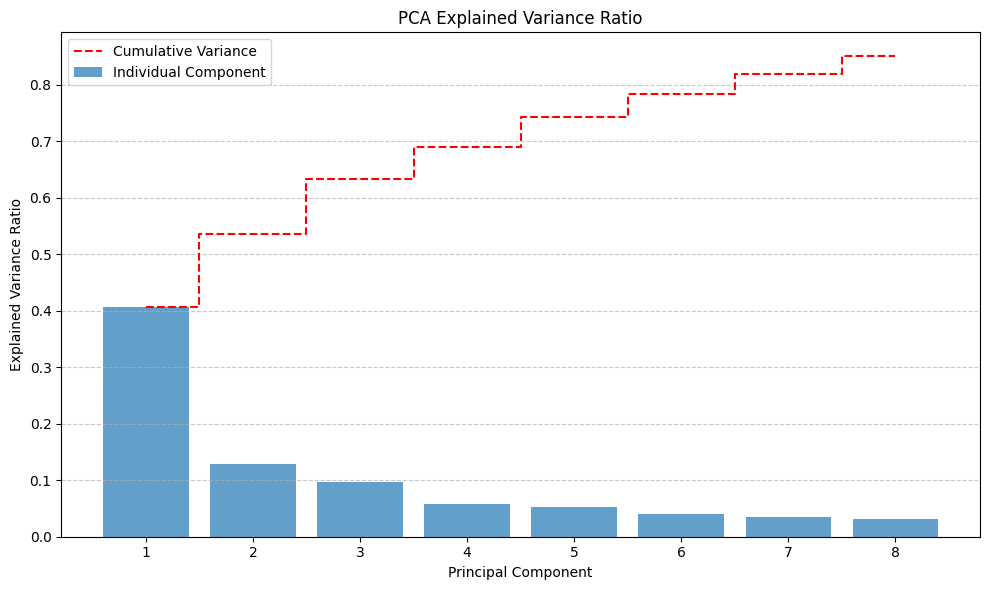

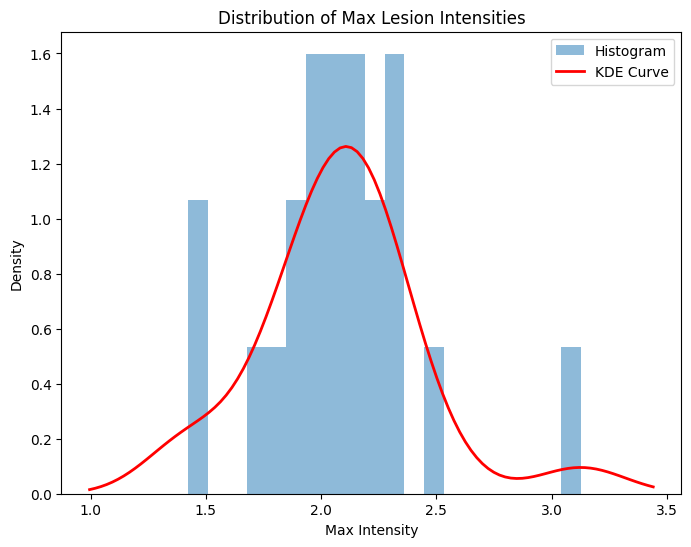

Image 0 Number of lesions to insert: 4
Image 1 Number of lesions to insert: 4
Error occurred in iteration 1: operands could not be broadcast together with shapes (182,256,85) (154,256,85) 
No lesion inserted
Image 3 Number of lesions to insert: 2
No lesion inserted
Image 5 Number of lesions to insert: 2
Image 6 Number of lesions to insert: 3
No valid (x, y) locations found at z-level 171. Skipping this lesion insertion.
No valid lesion inserted at z-level 0.8918918918918919. Skipping this lesion.
Error occurred in iteration 6: 'NoneType' object has no attribute 'GetPixelIDValue'
Image 7 Number of lesions to insert: 3
Image 8 Number of lesions to insert: 2
Image 9 Number of lesions to insert: 2
No lesion inserted
Image 11 Number of lesions to insert: 3
Image 12 Number of lesions to insert: 4
No lesion inserted
Image 14 Number of lesions to insert: 3
Image 15 Number of lesions to insert: 4
Image 16 Number of lesions to insert: 2
Image 17 Number of lesions to insert: 3
Image 18 Number of 

In [38]:
# 8b. Insert lesions into PET spinal canals and generate a dataset (images + lesion masks)
# =============================================================================================

import numpy as np
import SimpleITK as sitk
from scipy.ndimage import center_of_mass
import joblib
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import os
import nibabel as nib
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from scipy.ndimage import gaussian_filter
import scipy.ndimage as ndimage
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D

def load_image(path):
    """Load an image using SimpleITK."""
    return sitk.ReadImage(path)

def compute_center_of_mass(mask_array):
    """Compute the center of mass for a given mask array."""
    return center_of_mass(mask_array > 0)

def threshold_and_center_lesion(lesion_array, threshold=0.1):
    """Threshold the lesion and compute its center of mass."""
    lesion_array[lesion_array < threshold] = 0  # Apply threshold
    lesion_com = compute_center_of_mass(lesion_array)
    return lesion_array, lesion_com

def process_real_lesion(real_lesion_path):
    lesion_samples = []
    lesion_files = [f for f in os.listdir(real_lesion_path) if f.endswith('.nii.gz')]
    if not lesion_files:
        raise FileNotFoundError(f"No .nii.gz files found in {real_lesion_path}")

    # print(f"Found {len(lesion_files)} real lesion files. Processing...")
    for i, lesion_file in enumerate(lesion_files):
        lesion_file_path = os.path.join(real_lesion_path, lesion_file)
        # print(f"Processing real lesion {i+1}/{len(lesion_files)}: {lesion_file}")
        
        # Load lesion data and resize
        lesion_data = nib.load(lesion_file_path).get_fdata()
        lesion_samples.append(lesion_data.flatten())

    # Min-Max normalization for each lesion (row) based on its own min and max
    min_vals = np.min(lesion_samples, axis=1, keepdims=True)  # Min value for each lesion (row)
    max_vals = np.max(lesion_samples, axis=1, keepdims=True)  # Max value for each lesion (row)

    # Normalize each lesion (row) independently
    lesion_samples = (lesion_samples - min_vals) / (max_vals - min_vals)

    return lesion_samples

def pca_kde_sampling_with_plot(pca, pca_features, real_lesion_path, num_samples):

    real_lesion_samples = process_real_lesion(real_lesion_path)

    real_pca_features = pca.transform(real_lesion_samples)

    # Fit KDE for each PCA component
    kde_samples = []
    for i in range(pca_features.shape[1]):
        # Extract values of the i-th PCA component
        component_values = real_pca_features[:, i]

        # Fit KDE to the component
        kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(component_values[:, np.newaxis])

        # Sample new values for this component
        samples = kde.sample(num_samples).flatten()
        kde_samples.append(samples)

        # Plot the KDE distribution for the first 5 components
        x_d = np.linspace(min(component_values) - 0.5, max(component_values) + 0.5, 1000)
        log_dens = kde.score_samples(x_d[:, np.newaxis])
        plt.figure(figsize=(6, 4))
        plt.plot(x_d, np.exp(log_dens), label=f"Component {i+1} KDE")
        plt.hist(component_values, bins=20, density=True, alpha=0.5, label="Histogram")
        plt.title(f"KDE of PCA Component {i+1}")
        plt.xlabel("Value")
        plt.ylabel("Density")
        plt.legend()
        plt.grid()
        plt.show()

    kde_samples = np.stack(kde_samples, axis=1)

    return kde_samples

def pca_gmm_sampling_with_plot(pca, pca_features, real_lesion_path, num_samples):
    # Process real lesion data
    real_lesion_samples = process_real_lesion(real_lesion_path)

    # Apply PCA transformation to the real lesion data
    real_pca_features = pca.transform(real_lesion_samples)

    # Fit GMM on the PCA-transformed features
    gmm = GaussianMixture(n_components=5, covariance_type='full')
    gmm.fit(real_pca_features)

    # Sample new points from the GMM
    gmm_samples, _ = gmm.sample(num_samples)

    # Plot the GMM distribution in 2D (assuming 2 PCA components)
    if real_pca_features.shape[1] == 2:  # Only plot if it's 2D PCA for visualization
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Scatter plot of the original real data
        ax.scatter(real_pca_features[:, 0], real_pca_features[:, 1], alpha=0.7, c='blue', edgecolors='k')

        # Plot the sampled GMM points
        ax.scatter(gmm_samples[:, 0], gmm_samples[:, 1], alpha=0.7, c='red', edgecolors='k', marker='x')

        # Plot the GMM components as ellipses
        for i in range(gmm.n_components):
            mean = gmm.means_[i]
            cov = gmm.covariances_[i]
            
            # Create an ellipse for the covariance matrix of each Gaussian
            v, w = np.linalg.eigh(cov)
            v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
            w = w.T
            
            angle = np.arctan(w[0, 1] / w[0, 0]) * 180.0 / np.pi
            angle = 180.0 if angle < 0 else angle
            ell = Ellipse(xy=mean, width=v[0], height=v[1], angle=angle, color='red', alpha=0.5)
            ax.add_patch(ell)

        ax.set_title("PCA Components with GMM Sampling")
        ax.set_xlabel("First PCA Component")
        ax.set_ylabel("Second PCA Component")
        plt.grid(True)
        plt.show()

    # Plot in 3D with ellipsoids
    elif real_pca_features.shape[1] == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Scatter plot of the original real data
        ax.scatter(real_pca_features[:, 0], real_pca_features[:, 1], real_pca_features[:, 2], 
                   alpha=0.7, c='blue', edgecolors='k', label="Real Lesions")

        # Plot the sampled GMM points
        ax.scatter(gmm_samples[:, 0], gmm_samples[:, 1], gmm_samples[:, 2], 
                   alpha=0.7, c='red', edgecolors='k', marker='x', label="GMM Samples")

        # Plot the GMM components as ellipsoids
        for i in range(gmm.n_components):
            plot_ellipsoid(ax, gmm.means_[i], gmm.covariances_[i])

        ax.set_title("PCA Components with GMM Sampling (3D)")
        ax.set_xlabel("First PCA Component")
        ax.set_ylabel("Second PCA Component")
        ax.set_zlabel("Third PCA Component")
        ax.legend()
        plt.show()
    
    return gmm_samples

def preprocess_lesions_with_pca(real_lesion_path, pca, pca_features, lesion_shape=(12,12,12), pca_components=8):
    # Calculate and display explained variance
    # cumulative_variance = np.sum(pca.explained_variance_ratio_) * 100
    # print(f"Selected 100 components explain {cumulative_variance:.2f}% of the variance in the data.")

    # Display individual component variance
    # for i, variance in enumerate(pca.explained_variance_ratio_):
        # print(f"Component {i+1} explains {variance * 100:.2f}% of the variance")

    kde_samples = pca_gmm_sampling_with_plot(pca, pca_features, real_lesion_path, num_samples=1)
    return kde_samples

def plot_lesion_top_values_histogram_with_kde(lesion_values, bandwidth):

    # Compute KDE
    kde = gaussian_kde(lesion_values, bw_method='scott')
    kde.set_bandwidth(kde.factor * bandwidth)
    kde_x = np.linspace(min(lesion_values), max(lesion_values), 500)
    kde_y = kde(kde_x)

    return kde

def sample_from_kde(kde, num_samples=1):
    """
    Sample values from a KDE distribution.

    Parameters:
        kde (gaussian_kde): The KDE object fitted to lesion values.
        num_samples (int): Number of samples to draw.

    Returns:
        numpy.ndarray: Random samples from the KDE.
    """
    return kde.resample(num_samples).flatten()

def sample_z_level_from_kde(kde, num_samples=1):
    """Sample a z-level from the KDE distribution."""
    return kde.resample(num_samples).flatten()

def insert_lesion_into_petOLD(pet_image, mask_image, lesion_array, kde_z):
    """
    Insert a lesion into the PET image at a specific z-level sampled from the KDE distribution,
    scaling the maximum value of the lesion by a random factor between 1.0 and 1.25.

    If no valid (x, y) locations are found at the sampled z-level, the function skips insertion.
    """
    pet_array = sitk.GetArrayFromImage(pet_image)
    mask_array = sitk.GetArrayFromImage(mask_image)

    # Rescale the lesion's non-zero voxels by a random factor between 1.0 and 1.25
    scaling_factor = np.random.uniform(1, 1.25)
    lesion_array = np.where(lesion_array > 0.1, lesion_array * scaling_factor, lesion_array)

    # Get the z-level range from the non-zero mask
    non_zero_z = np.any(mask_array > 0, axis=(1, 2))
    non_zero_z_indices = np.where(non_zero_z)[0]

    if len(non_zero_z_indices) == 0:
        print("No valid z-levels found in the mask.")
        return None, None

    z_min, z_max = non_zero_z_indices[0], non_zero_z_indices[-1]
    z_level = z_min + kde_z * (z_max - z_min)
    z_level_index = int(np.round(z_level))
    z_level_index = max(z_min, min(z_max, z_level_index))

    # Get a random (x, y) location from the mask at the selected z-level
    mask_voxels = np.argwhere(mask_array[z_level_index] > 0)
    if mask_voxels.size == 0:
        print(f"No valid (x, y) locations found at z-level {z_level_index}. Skipping this lesion insertion.")
        return None, None

    random_xy_voxel = mask_voxels[random.randint(0, len(mask_voxels) - 1)]
    random_voxel = np.array([z_level_index, *random_xy_voxel])

    # Calculate the insertion region
    lesion_shape = lesion_array.shape
    lesion_com = np.array(compute_center_of_mass(lesion_array)).astype(int)
    start = random_voxel - lesion_com
    end = start + lesion_shape

    # Ensure the region is within bounds
    slices_pet, slices_lesion = [], []
    for i in range(3):
        lesion_start = max(0, -start[i])
        pet_start = max(0, start[i])
        pet_end = min(pet_array.shape[i], end[i])
        lesion_end = lesion_start + (pet_end - pet_start)

        slices_pet.append(slice(pet_start, pet_end))
        slices_lesion.append(slice(lesion_start, lesion_end))

    slices_pet = tuple(slices_pet)
    slices_lesion = tuple(slices_lesion)

    # Replace PET values with non-zero lesion values and create a binary mask
    binary_lesion_mask = np.zeros_like(pet_array, dtype=np.uint8)
    lesion_region = lesion_array[slices_lesion]
    pet_region = pet_array[slices_pet]

    # Insert only non-zero lesion values
    non_zero_mask = lesion_region > 0
    pet_region[non_zero_mask] = lesion_region[non_zero_mask]
    binary_lesion_mask[slices_pet][non_zero_mask] = 1

    # Save the modified PET image and binary mask
    pet_with_lesion = sitk.GetImageFromArray(pet_array)
    pet_with_lesion.CopyInformation(pet_image)

    binary_lesion_image = sitk.GetImageFromArray(binary_lesion_mask)
    binary_lesion_image.CopyInformation(pet_image)

    return pet_with_lesion, binary_lesion_image

def insert_lesion_into_pet(pet_image, mask_image, lesion_array, kde_z, sampled_kde_max):
    """
    Insert a lesion into the PET image at a specific z-level sampled from the KDE distribution,
    scaling the maximum value of the lesion by a factor based on the original max.

    The lesion intensity is rescaled so that its **minimum nonzero value** matches 
    the median PET value at the insertion location, while keeping the maximum unchanged.

    If no valid (x, y) locations are found at the sampled z-level, the function skips insertion.
    """
    pet_array = sitk.GetArrayFromImage(pet_image)
    mask_array = sitk.GetArrayFromImage(mask_image)

    # Compute the current maximum intensity of the lesion
    current_max = lesion_array.max()
    # Compute the scaling factor to match the new max intensity
    scaling_factor = sampled_kde_max / current_max if current_max > 0 else 1.0
    # Apply scaling only to nonzero intensities, keeping the minimum unchanged
    lesion_array = np.where(lesion_array > 0, lesion_array*scaling_factor, lesion_array)
    # plot_lesion_3d(lesion_array)

    # Get the z-level range from the non-zero mask
    non_zero_z = np.any(mask_array > 0, axis=(1, 2))
    non_zero_z_indices = np.where(non_zero_z)[0]

    if len(non_zero_z_indices) == 0:
        print("No valid z-levels found in the mask.")
        return None, None

    z_min, z_max = non_zero_z_indices[0], non_zero_z_indices[-1]
    z_level = z_min + kde_z * (z_max - z_min)
    z_level_index = int(np.round(z_level))
    z_level_index = max(z_min, min(z_max, z_level_index))

    # Get a random (x, y) location from the mask at the selected z-level
    mask_voxels = np.argwhere(mask_array[z_level_index] > 0)
    if mask_voxels.size == 0:
        print(f"No valid (x, y) locations found at z-level {z_level_index}. Skipping this lesion insertion.")
        return None, None

    random_xy_voxel = mask_voxels[random.randint(0, len(mask_voxels) - 1)]
    random_voxel = np.array([z_level_index, *random_xy_voxel])

    # Calculate the insertion region
    lesion_shape = lesion_array.shape
    lesion_com = np.array(compute_center_of_mass(lesion_array)).astype(int)
    start = random_voxel - lesion_com
    end = start + lesion_shape

    # Ensure the region is within bounds
    slices_pet, slices_lesion = [], []
    for i in range(3):
        lesion_start = max(0, -start[i])
        pet_start = max(0, start[i])
        pet_end = min(pet_array.shape[i], end[i])
        lesion_end = lesion_start + (pet_end - pet_start)

        slices_pet.append(slice(pet_start, pet_end))
        slices_lesion.append(slice(lesion_start, lesion_end))

    slices_pet = tuple(slices_pet)
    slices_lesion = tuple(slices_lesion)

    # Extract lesion and PET region for intensity rescaling
    lesion_region = lesion_array[slices_lesion]
    pet_region = pet_array[slices_pet]
    lesion_mask = lesion_region > 0

    if np.any(lesion_mask):
        pet_values_at_lesion = pet_region[lesion_mask]
        median_pet_value = np.median(pet_values_at_lesion)

        # Extract only nonzero lesion values for proper scaling
        lesion_nonzero = lesion_region[lesion_mask]
        lesion_max = lesion_nonzero.max()
        lesion_min = lesion_nonzero.min()

        if lesion_max - lesion_min > 0:
            lesion_rescaled = np.copy(lesion_region)
            lesion_rescaled[lesion_mask] = (lesion_nonzero - lesion_min) / (lesion_max - lesion_min)  # Normalize to [0,1]
            lesion_rescaled[lesion_mask] = lesion_rescaled[lesion_mask] * (lesion_max - median_pet_value) + median_pet_value  # Scale

            # Insert rescaled lesion into PET image
            pet_region[lesion_mask] = lesion_rescaled[lesion_mask]

    # Create a binary mask of the inserted lesion
    binary_lesion_mask = np.zeros_like(pet_array, dtype=np.uint8)
    binary_lesion_mask[slices_pet][lesion_mask] = 1

    # Save the modified PET image and binary mask
    pet_with_lesion = sitk.GetImageFromArray(pet_array)
    pet_with_lesion.CopyInformation(pet_image)

    binary_lesion_image = sitk.GetImageFromArray(binary_lesion_mask)
    binary_lesion_image.CopyInformation(pet_image)

    return pet_with_lesion, binary_lesion_image

def plot_pca_variance_explained(pca):
    """
    Plot the explained variance ratio for each PCA component.

    Parameters:
        pca (sklearn.decomposition.PCA): The PCA object containing the explained variance data.
    """
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 
            alpha=0.7, label='Individual Component')
    plt.step(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 
             where='mid', linestyle='--', color='red', label='Cumulative Variance')

    plt.title('PCA Explained Variance Ratio')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.xticks(range(1, len(explained_variance_ratio) + 1))
    plt.legend(loc='best')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def apply_affine_transform(image_array, mask_array, max_shear=0.04, max_translation=4):
    """
    Apply a small shear and translation to both the image and mask.

    Parameters:
        image_array (numpy.ndarray): The input PET image array.
        mask_array (numpy.ndarray): The input mask array.
        max_shear (float): Maximum shear value (small perturbation).
        max_translation (int): Maximum number of pixels for translation.

    Returns:
        tuple: (Transformed image array, Transformed mask array)
    """
    # Generate a small random shear matrix
    shear_x = np.random.uniform(-max_shear, max_shear)
    shear_y = np.random.uniform(-max_shear, max_shear)
    shear_z = np.random.uniform(-max_shear, max_shear)

    shear_matrix = np.array([
        [1, shear_x, shear_y, 0],
        [shear_x, 1, shear_z, 0],
        [shear_y, shear_z, 1, 0],
        [0, 0, 0, 1]
    ])

    # Generate a small random translation
    translation = np.random.randint(-max_translation, max_translation + 1, size=3)

    # Apply affine transformation to image and mask
    transformed_image = ndimage.affine_transform(image_array, shear_matrix[:3, :3], offset=translation, order=1)
    transformed_mask = ndimage.affine_transform(mask_array, shear_matrix[:3, :3], offset=translation, order=0)

    return transformed_image, transformed_mask

def add_noise_and_blur(image, noise_std=0.05, blur_sigma_range=(0.5, 2.0)):
    """
    Add small random noise and random blur to an image.
    
    Args:
        image (numpy.ndarray): The input image array.
        noise_std (float): Standard deviation of the Gaussian noise to be added.
        blur_sigma_range (tuple): The range (min, max) from which to sample the blur sigma value.
    
    Returns:
        numpy.ndarray: Augmented image.
    """
    # Add random Gaussian noise
    noise = np.random.normal(0, noise_std, image.shape)
    noisy_image = image + noise
    
    # Apply random Gaussian blur (sample sigma from blur_sigma_range)
    blur_sigma = np.random.uniform(blur_sigma_range[0], blur_sigma_range[1])
    transformed_image = gaussian_filter(noisy_image, sigma=blur_sigma)
    
    return transformed_image

def get_random_image_mask_pair(image_dir, mask_dir):
    """Randomly select an image and corresponding mask pair."""
    images = [f for f in os.listdir(image_dir) if f.endswith('_0001.nii.gz')]
    if not images:
        raise FileNotFoundError("No valid images found in directory.")
    
    selected_image = random.choice(images)
    mask_name = f"spinal_cord_{selected_image}"
    mask_path = os.path.join(mask_dir, mask_name)
    image_path = os.path.join(image_dir, selected_image)
    
    if not os.path.exists(mask_path):
        raise FileNotFoundError(f"Corresponding mask not found for {selected_image}.")
    
    return image_path, mask_path, selected_image[:-12]

def plot_lesion_3d(lesion_array):
    """ Plot the extracted lesion in 3D with a colorbar. """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    nonzero_voxels = np.argwhere(lesion_array > 0)
    values = lesion_array[lesion_array > 0]
    
    sc = ax.scatter(nonzero_voxels[:, 0], nonzero_voxels[:, 1], nonzero_voxels[:, 2], 
                    c=values, cmap='hot', marker='o')
    ax.set_title('3D Visualization of Extracted Lesion')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 12)
    ax.set_zlim(0, 12)
    fig.colorbar(sc, ax=ax, label='Voxel Intensity')
    plt.show()
    
def sample_z_from_kde(kde_values, z_range):
    # Use the KDE values to sample a z-level. We can use np.random.choice for sampling.
    z_level = np.random.choice(z_range, p=kde_values / kde_values.sum())  # Normalize the KDE
    return z_level

def plot_ellipsoid(ax, mean, cov, color='red', alpha=0.2):
    """Plot a correctly scaled 3D Gaussian ellipsoid."""
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 30)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))

    # Compute eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov)
    radii = 2.0 * np.sqrt(eigvals)  # Apply scaling factor for 95% confidence region

    # Transform unit sphere
    xyz = np.array([x.ravel(), y.ravel(), z.ravel()])
    transformed_xyz = eigvecs @ (radii[:, None] * xyz)  # Correct transformation
    x_t, y_t, z_t = transformed_xyz.reshape(3, *x.shape)

    # Shift ellipsoid to Gaussian mean
    x_t += mean[0]
    y_t += mean[1]
    z_t += mean[2]

    # Plot the ellipsoid
    ax.plot_surface(x_t, y_t, z_t, color=color, alpha=alpha, edgecolor='k')

    """Plot a 3D Gaussian as an ellipsoid based on mean and covariance matrix."""
    # Generate a sphere
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 30)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))

    # Compute eigenvalues and eigenvectors (axes and orientation)
    eigvals, eigvecs = np.linalg.eigh(cov)
    radii = np.sqrt(eigvals)  # Scale by standard deviation

    # Transform sphere by eigenvectors (rotation) and eigenvalues (scaling)
    xyz = np.array([x.ravel(), y.ravel(), z.ravel()])
    transformed_xyz = eigvecs @ (radii[:, None] * xyz)  # Apply transformation
    x_t, y_t, z_t = transformed_xyz.reshape(3, *x.shape)

    # Shift to mean
    x_t += mean[0]
    y_t += mean[1]
    z_t += mean[2]

    # Plot the ellipsoid
    ax.plot_surface(x_t, y_t, z_t, color=color, alpha=alpha, edgecolor='k')

# Load PCA model and features
pca_model_path = '//cifs.research.erasmusmc.nl/nuge0001/MartijnB/pca_model_real_lesions.joblib'
pca_features_path = '//cifs.research.erasmusmc.nl/nuge0001/MartijnB/pca_features_real_lesions.joblib'
pca = joblib.load(pca_model_path)
pca_features = joblib.load(pca_features_path)

# Call the function with your PCA object
plot_pca_variance_explained(pca)

image_dir = r"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\InsertionImages\images"
mask_dir = r"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\InsertionImages\masks"
real_lesion_path = r"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\ExtractedLesions"

# Load KDE distribution
kde_distribution_path = r'\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\kde_distribution.npy'
kde_data = np.load(kde_distribution_path, allow_pickle=True).item()
z_range = kde_data['z_range']
kde_values = kde_data['kde_values']

lesion_files = [f for f in os.listdir(real_lesion_path) if f.endswith('.nii') or f.endswith('.nii.gz')]

# Extract max intensity values
real_max_intensities = []
for file in lesion_files:
    img = nib.load(os.path.join(real_lesion_path, file))
    data = img.get_fdata()
    real_max_intensities.append(data.max())

real_max_intensities = np.array(real_max_intensities)

# Apply Kernel Density Estimation (KDE)
kde_max = gaussian_kde(real_max_intensities, bw_method='scott')

# Generate values for plotting KDE
x_vals = np.linspace(real_max_intensities.min()*0.7, real_max_intensities.max()*1.1, 100) # including -30% & +10% additional space
kde_vals = kde_max(x_vals)

# Plot histogram and KDE curve
plt.figure(figsize=(8, 6))
plt.hist(real_max_intensities, bins=20, density=True, alpha=0.5, label="Histogram")
plt.plot(x_vals, kde_vals, label="KDE Curve", color='r', linewidth=2)
plt.xlabel("Max Intensity")
plt.ylabel("Density")
plt.legend()
plt.title("Distribution of Max Lesion Intensities")
plt.show()

for i in range(25000):
    try:
        # Paths
        image_path, mask_path, patient_name = get_random_image_mask_pair(image_dir, mask_dir)

        pet_image = load_image(image_path)
        mask_image = load_image(mask_path)

        # Load total spinal canal segmentation mask
        spine_dir = fr"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_{patient_name}_0001.nii.gz"
        spine_image = load_image(spine_dir)

        # Generate a random number to decide the number of lesions
        rand_val = np.random.rand()
        num_lesions = 1  # Default is 1 lesion

        if rand_val < 0.20:
            print("No lesion inserted")

            # Keep original PET image and create an empty binary mask with the same size and metadata
            pet_with_lesion = pet_image
            combined_lesion_mask_image = sitk.Image(pet_image.GetSize(), sitk.sitkUInt8)
            combined_lesion_mask_image.CopyInformation(pet_image)

        else:
            # Determine the number of lesions to insert
            if rand_val < 0.40:
                num_lesions = 2
            elif rand_val < 0.60:
                num_lesions = 3
            elif rand_val < 0.80:
                num_lesions = 4
            print('Image', i, 'Number of lesions to insert:', num_lesions)

            pet_with_lesion = pet_image

            # Initialize combined lesion mask as a zero array
            combined_lesion_mask = np.zeros_like(mask_array, dtype=np.uint8)

            for lesion_count in range(num_lesions):
                # Generate lesion using PCA and KDE
                lesion_features = preprocess_lesions_with_pca(real_lesion_path, pca, pca_features)
                inverse_pca_flattened = pca.inverse_transform(lesion_features[0])
                inverse_pca_lesion = inverse_pca_flattened.reshape((12, 12, 12))
                inverse_pca_lesion[inverse_pca_lesion < 0.6] = 0  # Threshold for reconstruction artifacts

                # plot_lesion_3d(inverse_pca_lesion) # Show what inserted lesion looks like?
                # nib.save(nib.Nifti1Image(inverse_pca_lesion, affine=np.eye(4)), fr'\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\MockLesions\MockLesion_{i}.nii.gz')

                kde_z = sample_z_from_kde(kde_values, z_range) # Sample a z-level based on the KDE distribution
                sampled_kde_max = kde_max.resample(size=1)[0, 0] # Sample a max intensity based on the KDE distribution

                # Insert lesion into the augmented PET image
                pet_with_lesion, lesion_mask = insert_lesion_into_pet(pet_with_lesion, mask_image, inverse_pca_lesion, kde_z, sampled_kde_max)

                if lesion_mask is None:
                    print(f"No valid lesion inserted at z-level {kde_z}. Skipping this lesion.")
                    continue  # Skip this lesion and move to the next one

                # Combine lesion masks (ensure it's always binary)
                lesion_mask_array = sitk.GetArrayFromImage(lesion_mask)
                combined_lesion_mask = np.logical_or(combined_lesion_mask, lesion_mask_array).astype(np.uint8)

            # Convert combined lesion mask back to SimpleITK image
            combined_lesion_mask_image = sitk.GetImageFromArray(combined_lesion_mask)
            combined_lesion_mask_image.CopyInformation(mask_image)
        
        # Convert images to NumPy arrays
        pet_array = sitk.GetArrayFromImage(pet_with_lesion)
        lesion_mask_array = sitk.GetArrayFromImage(combined_lesion_mask_image)
        spine_mask_array = sitk.GetArrayFromImage(spine_image)

        # Perform element-wise multiplication
        pet_array *= spine_mask_array
        lesion_mask_array *= spine_mask_array

        pet_array, lesion_mask_array = apply_affine_transform(pet_array, lesion_mask_array)

        # Find nonzero voxel indices
        nonzero_coords = np.argwhere(pet_array > 0)
        min_z, min_y, min_x = nonzero_coords.min(axis=0)
        max_z, max_y, max_x = nonzero_coords.max(axis=0)

        # Crop the arrays using the bounding box
        pet_cropped = pet_array[min_z:max_z+1, min_y:max_y+1, min_x:max_x+1]
        lesion_mask_cropped = lesion_mask_array[min_z:max_z+1, min_y:max_y+1, min_x:max_x+1]

        # Convert back to SimpleITK images
        pet_cropped_image = sitk.GetImageFromArray(pet_cropped)
        lesion_mask_cropped_image = sitk.GetImageFromArray(lesion_mask_cropped)

        # Preserve spacing & direction
        pet_cropped_image.SetSpacing(pet_with_lesion.GetSpacing())
        pet_cropped_image.SetDirection(pet_with_lesion.GetDirection())

        lesion_mask_cropped_image.SetSpacing(combined_lesion_mask_image.GetSpacing())
        lesion_mask_cropped_image.SetDirection(combined_lesion_mask_image.GetDirection())

        # Compute the new origin (shifted due to cropping)
        original_origin = np.array(pet_with_lesion.GetOrigin())
        spacing = np.array(pet_with_lesion.GetSpacing())

        new_origin = original_origin + spacing * np.array([min_x, min_y, min_z])

        # Set the new origin for cropped images
        pet_cropped_image.SetOrigin(tuple(new_origin))
        lesion_mask_cropped_image.SetOrigin(tuple(new_origin))
        
        # Save the cropped images
        sitk.WriteImage(pet_cropped_image, fr"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\imagesTr\image_{int(i):06d}_{patient_name}_{num_lesions}_0000.nii.gz")
        sitk.WriteImage(lesion_mask_cropped_image, fr"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\labelsTr\image_{int(i):06d}_{patient_name}_{num_lesions}.nii.gz")

    except Exception as e:
        print(f"Error occurred in iteration {i}: {e}")
        continue  # Skip this iteration and continue with the next one

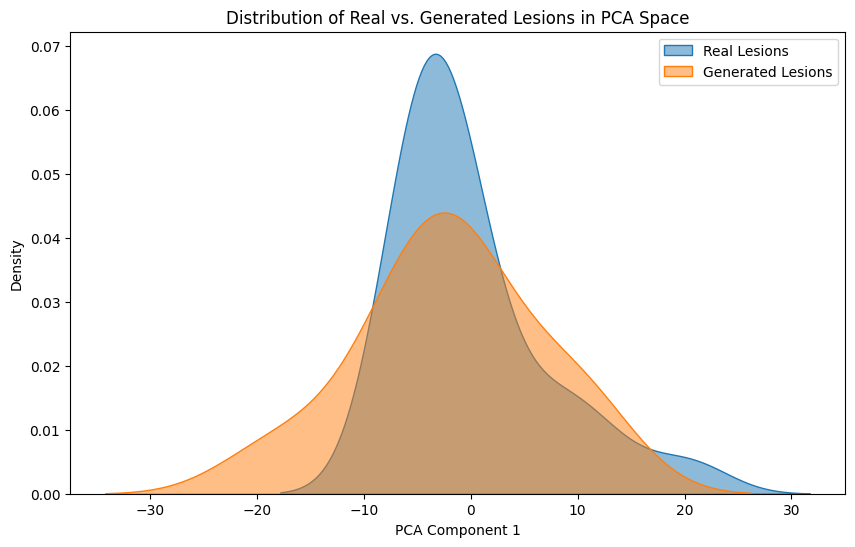

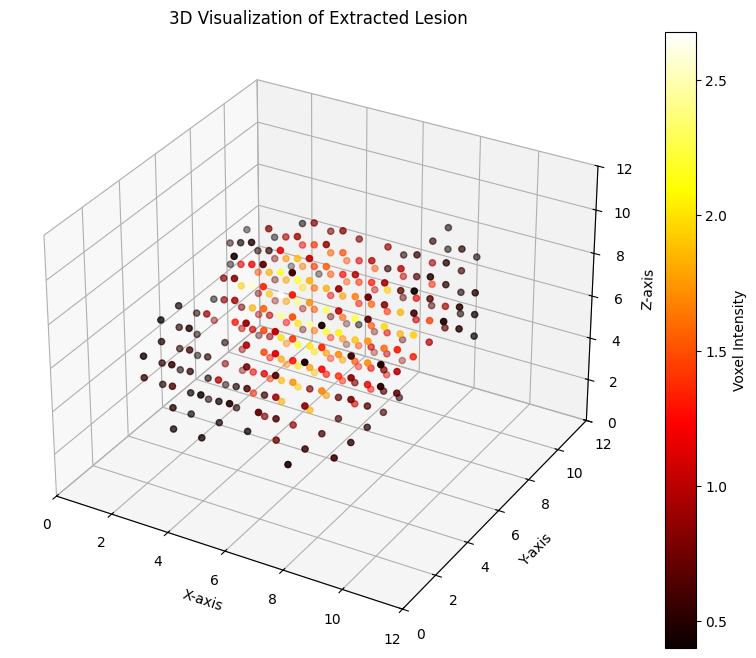

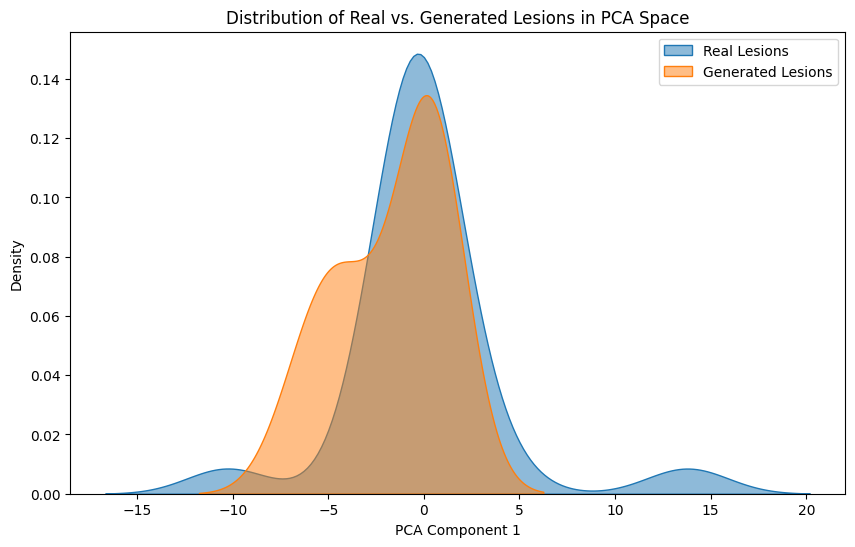

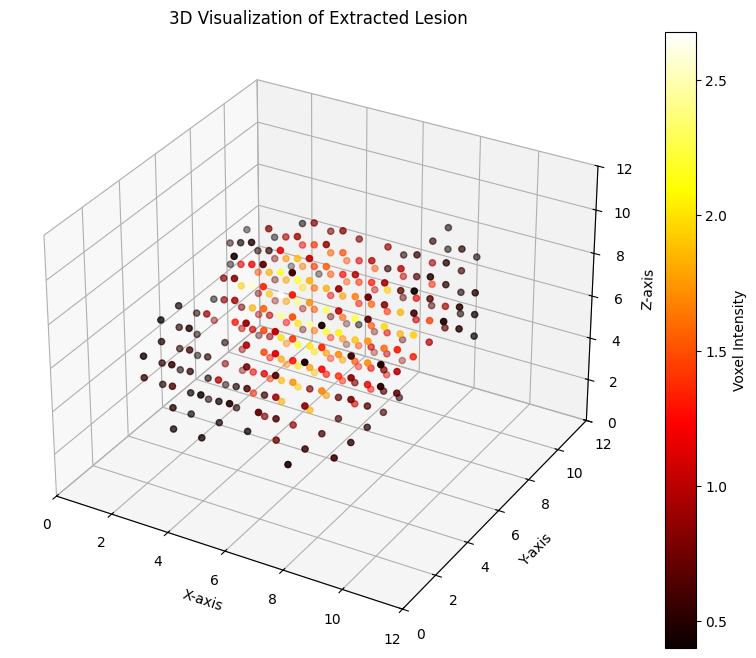

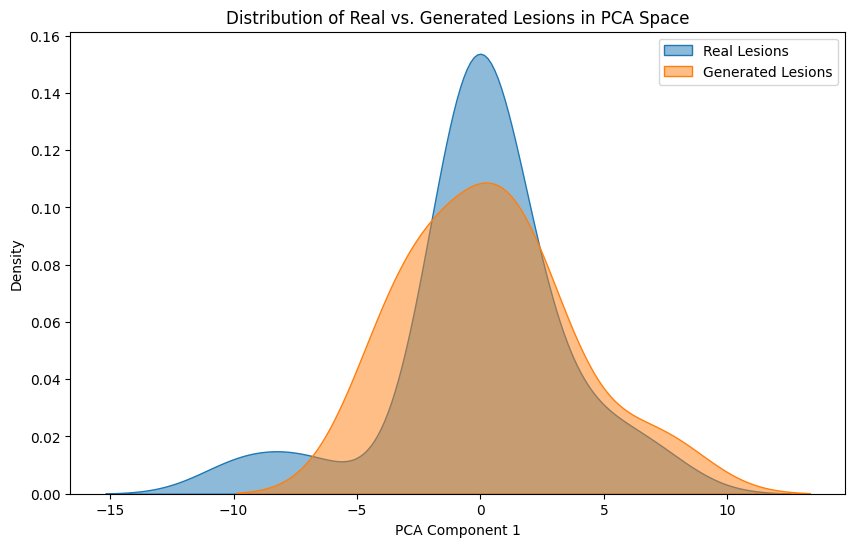

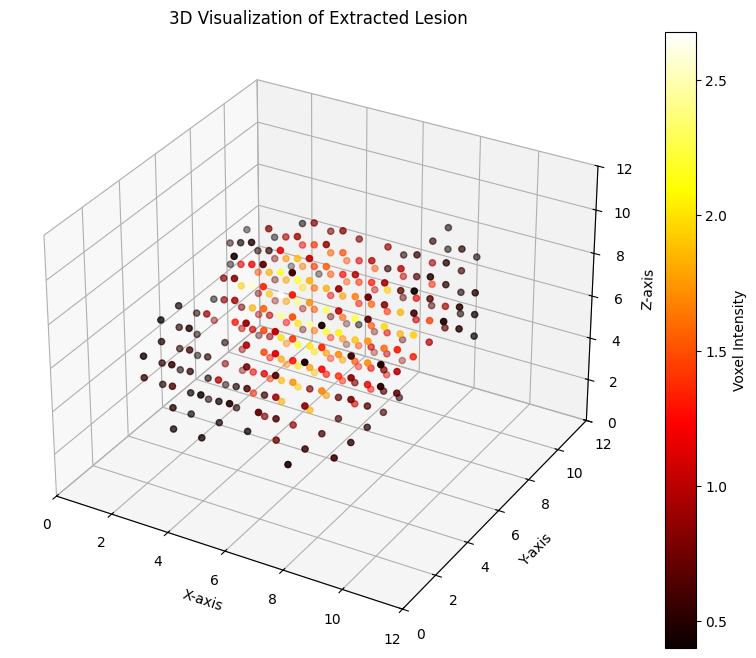

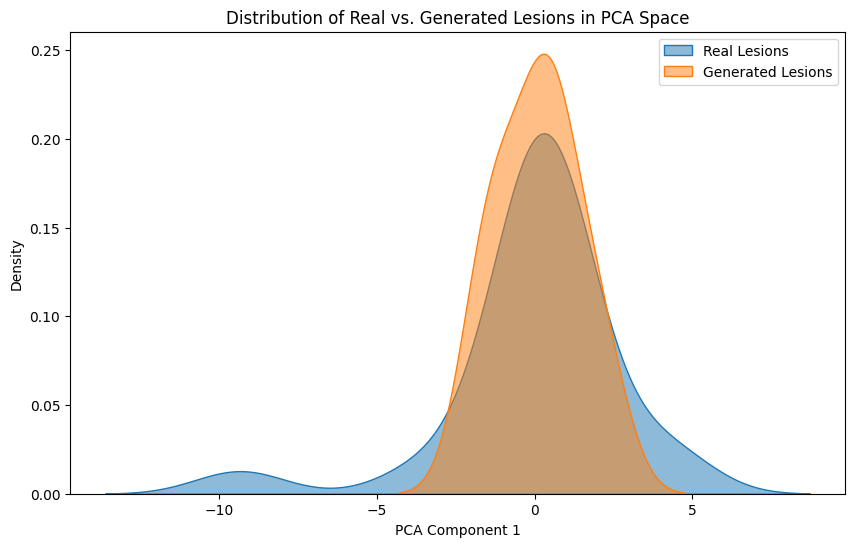

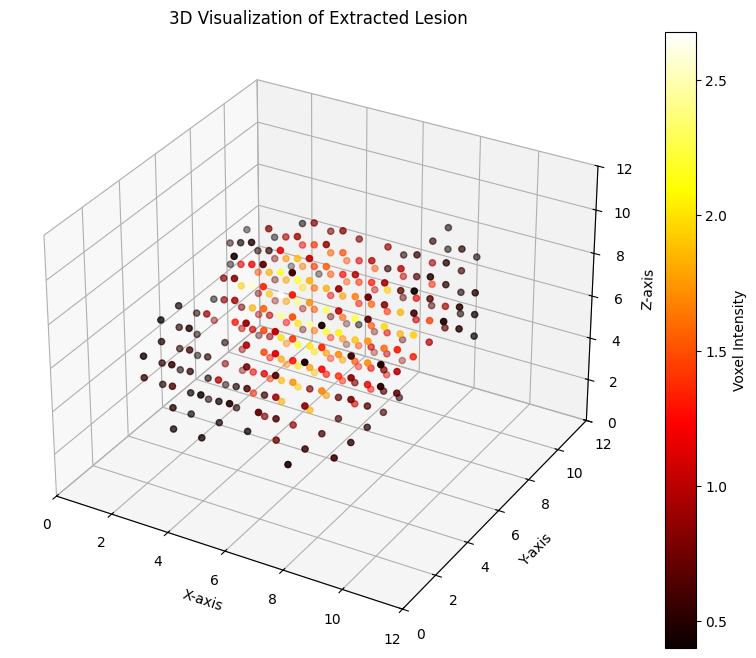

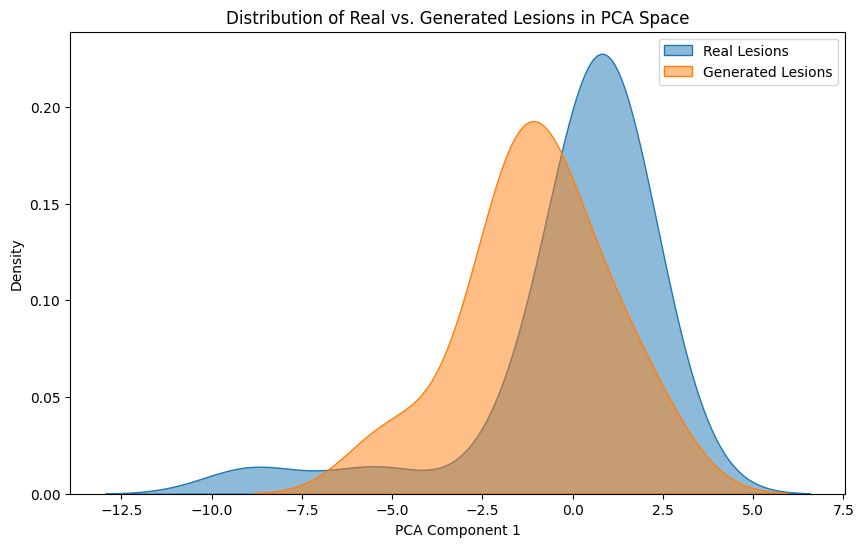

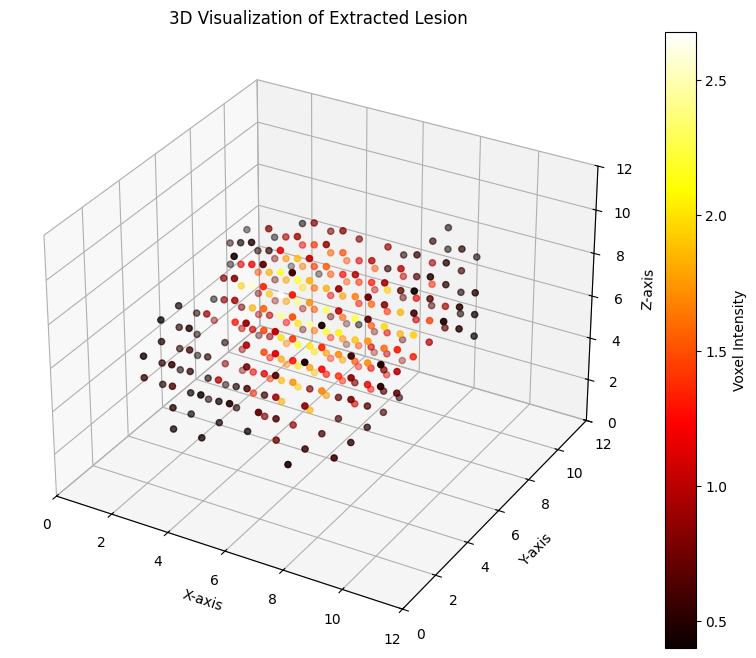

In [61]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# Load PCA model and real lesion features
pca_model_path = '//cifs.research.erasmusmc.nl/nuge0001/MartijnB/pca_model_real_lesions.joblib'
pca_features_path = '//cifs.research.erasmusmc.nl/nuge0001/MartijnB/pca_features_real_lesions.joblib'
pca = joblib.load(pca_model_path)
real_pca_features = joblib.load(pca_features_path)  # Shape: (num_lesions, num_pca_components)

# Function to generate mock lesions by sampling from PCA space
def generate_mock_lesions(n=1000):
    """
    Generates n synthetic lesions by sampling from the PCA distribution.
    Returns: mock_lesion_features (n, num_pca_components)
    """
    mean = np.mean(real_pca_features, axis=0)
    cov = np.cov(real_pca_features, rowvar=False)  # Covariance of real lesion PCA features
    sampled_pca_features = np.random.multivariate_normal(mean, cov, size=n)
    
    return sampled_pca_features

# Generate 1000 synthetic lesions in PCA space
mock_pca_features = generate_mock_lesions(n=10)
for i in range(5):
    # Compare distributions of PCA components
    plt.figure(figsize=(10, 6))
    sns.kdeplot(real_pca_features[:, i], label='Real Lesions', fill=True, alpha=0.5)
    sns.kdeplot(mock_pca_features[:, i], label='Generated Lesions', fill=True, alpha=0.5)
    plt.xlabel("PCA Component 1")
    plt.ylabel("Density")
    plt.title("Distribution of Real vs. Generated Lesions in PCA Space")
    plt.legend()
    plt.show()

    # Reconstruct a sample lesion from PCA space
    sample_mock_lesion = pca.inverse_transform(mock_pca_features[0])  # First generated lesion
    sample_mock_lesion = sample_mock_lesion.reshape((12, 12, 12))  # Reshape back into 3D
    sample_mock_lesion[sample_mock_lesion < 0.4] = 0  # Threshold for reconstruction artifacts

    # Plot the 3D reconstruction of the synthetic lesion
    plot_lesion_3d(sample_mock_lesion)


Mean Dice Score: 0.8817 ± 0.0761
Mean Lesion Recall: 0.6895 ± 0.4089
Mean Lesion Precision: 1.0000 ± 0.0000
Mean Ground Truth Lesions: 1.72 ± 1.25
Mean Predicted Lesions: 1.69 ± 1.24
Under-segmented Cases: 42
Over-segmented Cases: 0


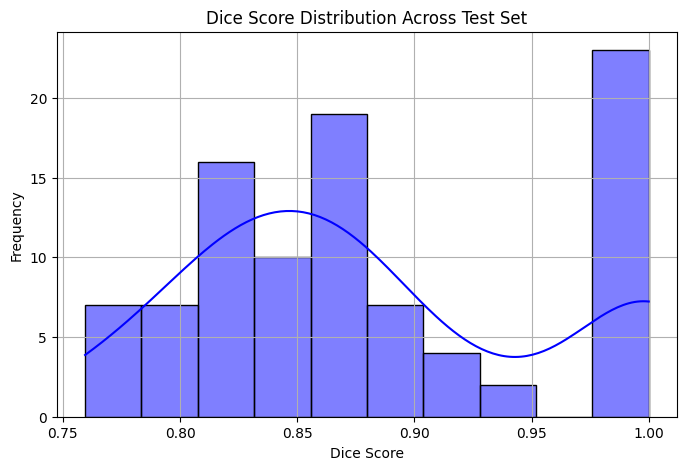

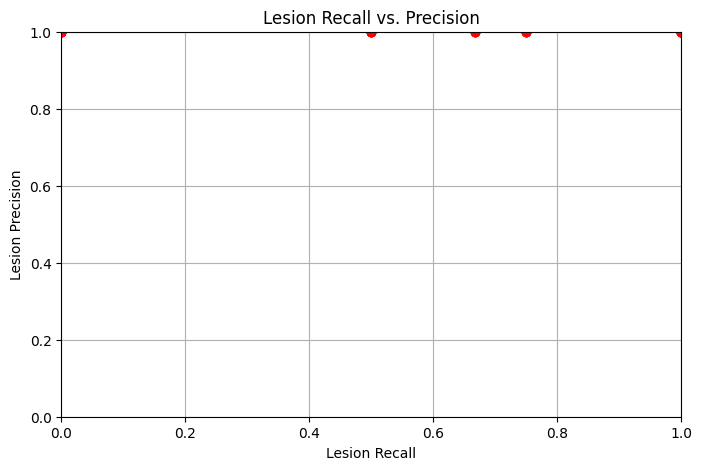

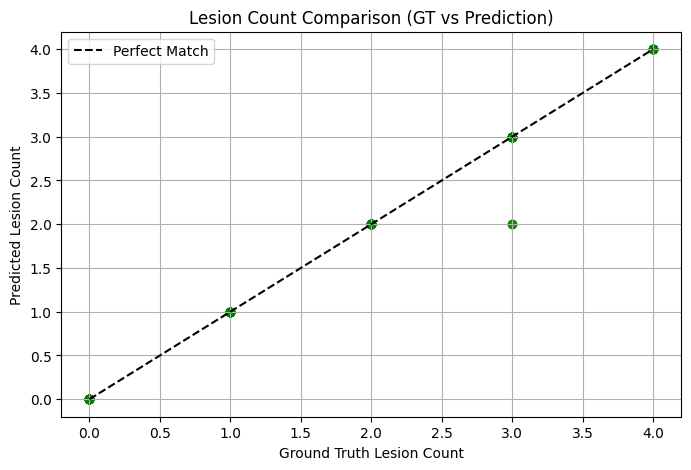

In [42]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import label

# Paths to folders
gt_dir = r"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\ValidationSet\labelsTr"
pred_dir = r"C:\Users\r106186\Desktop\DetectionResults\Results2"

# Get filenames
gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith(".nii.gz")])
pred_files = sorted([f for f in os.listdir(pred_dir) if f.endswith(".nii.gz")])

# Ensure filenames match
assert set(gt_files) == set(pred_files), "Mismatch in filenames between ground truth and predictions"

# Function to compute Dice score
def dice_coefficient(gt, pred):
    intersection = np.sum(gt * pred)
    sum_gt_pred = np.sum(gt) + np.sum(pred)
    return 2.0 * intersection / sum_gt_pred if sum_gt_pred > 0 else 1.0 if np.sum(gt) == np.sum(pred) == 0 else 0.0

# Function to count valid connected components
def count_valid_lesions(mask, min_size=10):
    labeled_mask, num_components = label(mask)
    valid_count = sum(np.sum(labeled_mask == i) >= min_size for i in range(1, num_components + 1))
    return valid_count

# Store results
dice_scores = []
lesion_recall = []
lesion_precision = []
gt_lesion_counts = []
pred_lesion_counts = []
undersegmentation_cases = 0
oversegmentation_cases = 0

for file in gt_files:
    # Load ground truth and predicted mask
    gt_nifti = nib.load(os.path.join(gt_dir, file))
    pred_nifti = nib.load(os.path.join(pred_dir, file))

    gt_mask = gt_nifti.get_fdata() > 0
    pred_mask = pred_nifti.get_fdata() > 0

    # Compute Dice coefficient
    dice = dice_coefficient(gt_mask, pred_mask)
    dice_scores.append(dice)

    # Extract number of lesions from filename (_{i}.nii.gz)
    num_gt_lesions = int(file.split("_")[-1].split(".")[0])  # Extract lesion count from filename

    # Count valid connected components (excluding tiny noise)
    num_gt_connected = count_valid_lesions(gt_mask, min_size=10)
    num_pred_connected = count_valid_lesions(pred_mask, min_size=10)

    gt_lesion_counts.append(num_gt_connected)
    pred_lesion_counts.append(num_pred_connected)

    # Compute recall and precision
    recall = min(num_pred_connected, num_gt_lesions) / num_gt_lesions if num_gt_lesions > 0 else 1.0
    precision = min(num_pred_connected, num_gt_lesions) / num_pred_connected if num_pred_connected > 0 else 1.0
    
    lesion_recall.append(recall)
    lesion_precision.append(precision)

    # Count under- and over-segmentation cases
    if num_pred_connected < num_gt_lesions:
        undersegmentation_cases += 1
    elif num_pred_connected > num_gt_lesions:
        oversegmentation_cases += 1

# Convert to NumPy arrays for statistics
dice_scores = np.array(dice_scores)
lesion_recall = np.array(lesion_recall)
lesion_precision = np.array(lesion_precision)
gt_lesion_counts = np.array(gt_lesion_counts)
pred_lesion_counts = np.array(pred_lesion_counts)

# Compute mean and std
mean_dice = np.mean(dice_scores)
std_dice = np.std(dice_scores)
mean_recall = np.mean(lesion_recall)
std_recall = np.std(lesion_recall)
mean_precision = np.mean(lesion_precision)
std_precision = np.std(lesion_precision)
mean_gt_lesions = np.mean(gt_lesion_counts)
std_gt_lesions = np.std(gt_lesion_counts)
mean_pred_lesions = np.mean(pred_lesion_counts)
std_pred_lesions = np.std(pred_lesion_counts)

# Print statistics
print(f"Mean Dice Score: {mean_dice:.4f} ± {std_dice:.4f}")
print(f"Mean Lesion Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean Lesion Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Ground Truth Lesions: {mean_gt_lesions:.2f} ± {std_gt_lesions:.2f}")
print(f"Mean Predicted Lesions: {mean_pred_lesions:.2f} ± {std_pred_lesions:.2f}")
print(f"Under-segmented Cases: {undersegmentation_cases}")
print(f"Over-segmented Cases: {oversegmentation_cases}")

# Plot Dice Score Distribution
plt.figure(figsize=(8, 5))
sns.histplot(dice_scores, bins=10, kde=True, color="blue")
plt.xlabel("Dice Score")
plt.ylabel("Frequency")
plt.title("Dice Score Distribution Across Test Set")
plt.grid(True)
plt.show()

# Plot Recall vs. Precision
plt.figure(figsize=(8, 5))
plt.scatter(lesion_recall, lesion_precision, color='red', alpha=0.7)
plt.xlabel("Lesion Recall")
plt.ylabel("Lesion Precision")
plt.title("Lesion Recall vs. Precision")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Plot GT vs Predicted Lesion Counts
plt.figure(figsize=(8, 5))
plt.scatter(gt_lesion_counts, pred_lesion_counts, color="green", alpha=0.7)
plt.xlabel("Ground Truth Lesion Count")
plt.ylabel("Predicted Lesion Count")
plt.title("Lesion Count Comparison (GT vs Prediction)")
plt.plot([0, max(gt_lesion_counts)], [0, max(gt_lesion_counts)], "k--", label="Perfect Match")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# 10. SPINAL CORD SEGMENTATION OF RESAMPLED MR IMAGES (for example, for inference!)
# ==================================================================================
import subprocess
import os
import nibabel as nib
import numpy as np

# Define input and output directories
input_directory = r"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\NewAlignedMRCUT"
output_dir = r"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\InsertionImages\masks"

# Segmentation task
task = 'total_mr'

# Iterate over all NIfTI images in the input directory
for filename in os.listdir(input_directory):
    if filename.endswith('.nii') or filename.endswith('.nii.gz'):
        patient_name = os.path.splitext(os.path.splitext(filename)[0])[0]  # Remove double extensions if needed
        nifti_image_path = os.path.join(input_directory, filename)

        # Run segmentation command
        command = [
            'TotalSegmentator',
            '-i', nifti_image_path,
            '-o', output_dir,
            '--task', task
        ]
        
        print(f"Processing {filename}...")
        result = subprocess.run(command, capture_output=True, text=True)
        
        # Check if the process ran successfully
        if result.returncode != 0:
            print(f"Error processing {filename}: {result.stderr}")
            continue

        # Define the path to the extracted spinal cord segmentation
        spinal_cord_path = os.path.join(output_dir, 'spinal_cord.nii.gz')
        
        # Check if the spinal cord file exists and rename it
        if os.path.exists(spinal_cord_path):
            new_spinal_cord_path = os.path.join(output_dir, f"spinal_cord_{patient_name}.nii.gz")
            os.rename(spinal_cord_path, new_spinal_cord_path)
            print(f"Renamed {spinal_cord_path} -> {new_spinal_cord_path}")
        else:
            print(f"spinal_cord.nii.gz not found for {filename}.")
